In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp, odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# set the path to the project directory
# os.chdir('/Users/olarinoyem/Project/data_driven_vaccination/')

os.chdir("/Users/ajaoo/Desktop/Projects/data_driven_vaccination")

In [2]:
# Set up matplotlib
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    # Font settings for clarity and compatibility with academic publications
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 14,  # Base font size for better readability
    "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
    
    # Figure aesthetics & size for detailed visuals and fit on publication pages
    "figure.figsize": [8, 6],  # Default figure size
    "figure.facecolor": "white",  # White figure background for clean print
    "figure.autolayout": True,  # Automatic layout adjustments
    "figure.dpi": 600,  # High resolution figures for publication quality
    "savefig.dpi": 600,  # High resolution saving settings
    "savefig.format": "pdf",  # Save figures in PDF format for publications
    "savefig.bbox": "tight",  # Tight bounding box around figures
    
    
    #title, xlabel and ylabel bold
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    
    
    # Axes aesthetics for clarity and precision
    "axes.labelsize": 12,
    "axes.titlesize": 18,  # Prominent titles for immediate recognition
    "axes.facecolor": "white",  # White axes background
    "axes.grid": False,  # Enable grid for better readability
    "axes.spines.top": False,  # Disable top spine for aesthetic purposes
    "axes.spines.right": False,  # Disable right spine for aesthetic purposes
    "axes.formatter.limits": (0, 5),  # Threshold for scientific notation
    "axes.formatter.use_mathtext": True,  # Use mathtext for scientific notations
    "axes.formatter.useoffset": False,  # Disable offset on axes
    "axes.xmargin": 0,  # No margin around x-axis
    "axes.ymargin": 0,  # No margin around y-axis
    # Legend aesthetics
    "legend.fontsize": 12,
    "legend.frameon": False,  # No frame around legend for cleaner look
    "legend.loc": "best",  # Optimal legend positioning
    
    # Line aesthetics
    "lines.linewidth": 2,  # Thicker lines for visibility
    "lines.markersize": 8,  # Slightly smaller markers for balance
    
    # Tick aesthetics
    "xtick.labelsize": 12,
    "xtick.direction": "in",  # Ticks inside the plot
    "xtick.top": False,  # Disable top ticks for aesthetic purposes
    "ytick.labelsize": 12,
    "ytick.direction": "in",  # Ticks inside the plot
    "ytick.right": False,  # Disable right ticks for aesthetic purposes
    
    # Grid settings
    "grid.color": "grey",  # Grid color
    "grid.linestyle": "--",  # Dashed grid lines
    "grid.linewidth": 0.5,  # Thin grid lines
    
    # Error bar aesthetics
    "errorbar.capsize": 4,  # Error bar cap length
    
    # Layout settings
    "figure.subplot.wspace": 0.4,  # Adjust horizontal spacing between subplots
    "figure.subplot.hspace": 0.4,  # Adjust vertical spacing between subplots
    
    # Latex and color map settings
    "image.cmap": "viridis",  # Preferred color map for images
    "text.latex.preamble": r"\usepackage{amsmath}",  # Latex preamble for math expressions
})

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load the data and check the first few rows
df = pd.read_csv("data/processed/england_data.csv").drop(columns=["Unnamed: 0"], axis=1)
df.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England


In [4]:
params = {
    "alpha": 0.1,  # Rate of transmission from the infected not requiring hospitalization
    "sigma": 0.1,  # Rate of transmission from the infected requiring hospitalization
    "beta": 0.17,  # Rate of transmission from the infected requiring hospitalization
    "gamma": 1 / 16,  # Recovery rate
    "theta": 0.001,  # Mortality rate
    "N": 56171302,  # Total population for England
    # Parameters for hospitalized and critical
    "rho": 0.05,  # Hospitalization rate for infected
    "delta": 0.01,  # Mortality rate for non-hospitalized
    "eta": 0.02,  # Rate at which hospitalized become critical
    "kappa": 0.03,  # Recovery rate for hospitalized
    "mu": 0.01,  # Recovery rate for critical
    "xi": 0.005,  # Mortality rate for critical
}

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [params["N"] - 1, 1, 0, 0, 0, 0]

In [5]:
def load_and_preprocess_data(
    filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"
):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date",
        "cumulative_confirmed",
        "cumulative_deceased",
        "population",
        "covidOccupiedMVBeds",
        "hospitalCases",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df[
        "cumulative_deceased"
    ].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = (
        df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    )

    # Estimate the susceptible population
    df["S(t)"] = (
        df["population"]
        - df["active_cases"]
        - df["recovered"]
        - df["cumulative_deceased"]
    )

    # Apply rolling average
    for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased"]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[
        ["recovered", "active_cases", "S(t)"]
    ].clip(lower=0)

    return df


def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        train_size (float): Proportion of the dataset to allocate to training.
        val_size (float): Proportion of the dataset to allocate to validation.
        test_size (float): Proportion of the dataset to allocate to testing.

    Returns:
        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

In [6]:
data = load_and_preprocess_data(
    "data/processed/england_data.csv",
    recovery_period=21,
    rolling_window=7,
    start_date="2020-04-01",
).drop("Unnamed: 0", axis=1)

data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.000000,31201,15544.000000,4382,3989.0,694.000000,35571.000000,4730.00,56171302,England,0,0.0,30841.000000,56135731.0
1,2020-04-02,939.000000,35138,15454.000000,3937,3895.0,709.500000,37518.500000,5092.50,56171302,England,1,0.0,32426.000000,56131836.0
2,2020-04-03,1379.666667,38526,16355.333333,3388,3878.0,718.666667,39460.333333,5459.00,56171302,England,2,0.0,34001.333333,56127958.0
3,2020-04-04,1649.250000,41972,17388.750000,3446,3260.0,746.000000,41246.250000,5849.25,56171302,England,3,0.0,35397.000000,56124698.0
4,2020-04-05,1849.400000,45418,18321.200000,3446,2994.0,761.400000,42916.600000,6248.00,56171302,England,4,0.0,36668.600000,56121704.0


In [7]:
# select from the beginning of the pandemic in the data to the end of 2021
data = data[(data["date"] >= "2020-04-01") & (data["date"] <= "2020-10-31")]
test_data = data[(data["date"] >= "2020-10-31") & (data["date"] <= "2020-12-31")]

data = data.reset_index(drop=True)
data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.000000,31201,15544.000000,4382,3989.0,694.000000,35571.000000,4730.00,56171302,England,0,0.0,30841.000000,56135731.0
1,2020-04-02,939.000000,35138,15454.000000,3937,3895.0,709.500000,37518.500000,5092.50,56171302,England,1,0.0,32426.000000,56131836.0
2,2020-04-03,1379.666667,38526,16355.333333,3388,3878.0,718.666667,39460.333333,5459.00,56171302,England,2,0.0,34001.333333,56127958.0
3,2020-04-04,1649.250000,41972,17388.750000,3446,3260.0,746.000000,41246.250000,5849.25,56171302,England,3,0.0,35397.000000,56124698.0
4,2020-04-05,1849.400000,45418,18321.200000,3446,2994.0,761.400000,42916.600000,6248.00,56171302,England,4,0.0,36668.600000,56121704.0


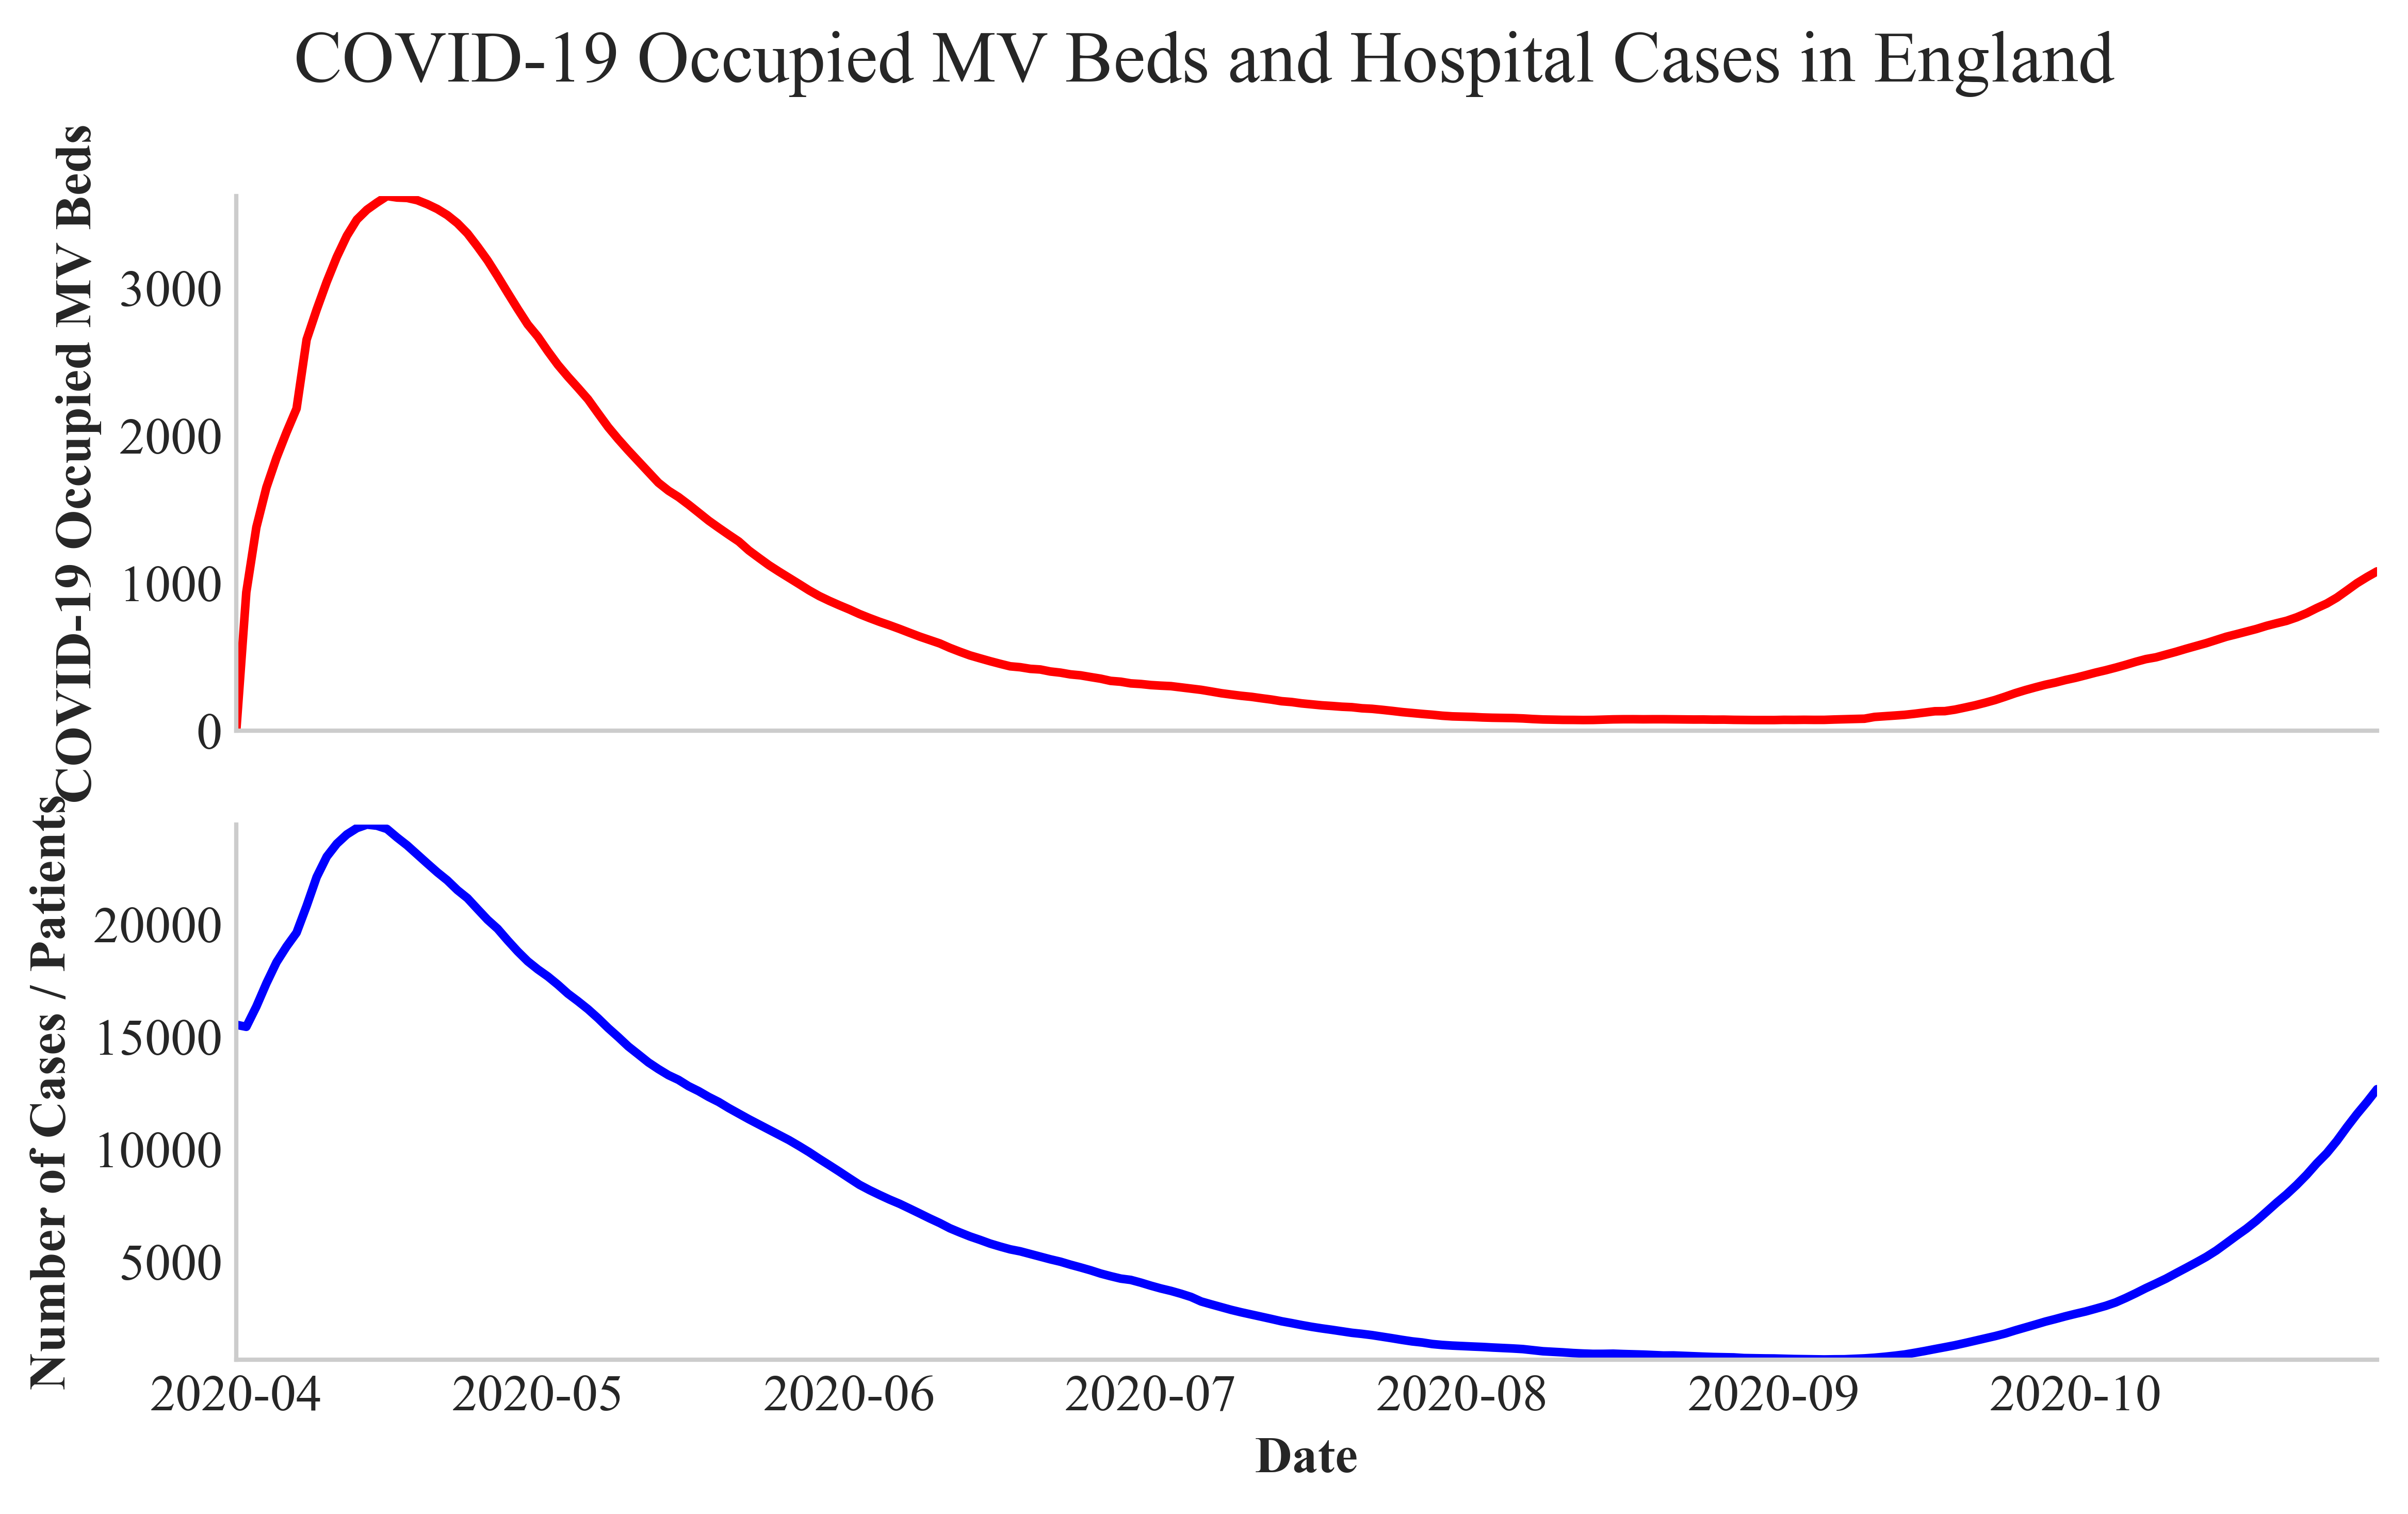

In [8]:
# visualize covidOccupiedMVBeds and hospitalCases on separate subplots sharing x-axis
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# Plotting COVID-19 Occupied MV Beds
ax[0].plot(data["date"], data["covidOccupiedMVBeds"], color="red")
ax[0].set_ylabel("COVID-19 Occupied MV Beds")

# Plotting Hospital Cases
ax[1].plot(data["date"], data["hospitalCases"], color="blue")
ax[1].set_ylabel("Hospital Cases")

# Setting a common x-label
plt.xlabel("Date")
plt.ylabel("Number of Cases / Patients")

# Adding a super title for the figure
plt.suptitle("COVID-19 Occupied MV Beds and Hospital Cases in England")

# Adjust the layout to make room for the shared legend
plt.tight_layout()  # Adjust the rect to leave space for the legend
# rect=[0, 0, 1, 0.95]
# Create a single legend for the whole figure in the top left corner
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.9, 0.9))

# Save the figure
plt.savefig("reports/figures/england_covid_occupied_mv_beds_hospital_cases.pdf")

# Show the plot
plt.show()

In [9]:
# Split the data into training, validation, and test sets and scale the training data
# train_data, val_data, test_data = split_time_series_data(
#     data, train_size=0.7, val_size=0.15, test_size=0.15
# )

scaler = MinMaxScaler()

In [10]:

def prepare_tensors(data, device):
    # t should be the length of the data starting from 1
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    H = tensor(data["hospitalCases"].values, dtype=torch.float32).view(-1, 1).to(device)
    C = (
        tensor(data["covidOccupiedMVBeds"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    return t, S, I, R, D, H, C


# Define the specific features used in the model
model_features = ['S(t)', 'active_cases', 'hospitalCases', 'covidOccupiedMVBeds', 'recovered', 'new_deceased']

# Fit the scaler only to these model features
scaler.fit(data[model_features])

# Transform the training, validation, and test data
data_scaled = pd.DataFrame(scaler.transform(data[model_features]), columns=model_features, index=data.index)
test_data_scaled = pd.DataFrame(scaler.transform(test_data[model_features]), columns=model_features, index=test_data.index)
# val_data_scaled = pd.DataFrame(scaler.transform(val_data[model_features]), columns=model_features, index=val_data.index)
# test_data_scaled = pd.DataFrame(scaler.transform(test_data[model_features]), columns=model_features, index=test_data.index)

# Prepare tensors for each dataset using the updated scaled data
t_data, S_data, I_data, R_data, D_data, H_data, C_data  = prepare_tensors(data_scaled, device)
t_test, S_test, I_test, R_test, D_test, H_test, C_test = prepare_tensors(test_data_scaled, device)
# t_val, S_val, I_val, R_val, D_val, H_val, C_val = prepare_tensors(val_data_scaled, device)
# t_test, S_test, I_test, R_test, D_test, H_test, C_test = prepare_tensors(test_data_scaled, device)

# Concatenate the tensors for each set
SIHCRD_tensor = torch.cat((S_data, I_data, H_data, C_data, R_data, D_data), dim=1)
# SIHCRD_tensor_val = torch.cat((S_val, I_val, H_val, C_val, R_val, D_val), dim=1)
# SIHCRD_tensor_test = torch.cat((S_test, I_test, H_test, C_test, R_test, D_test), dim=1)


In [11]:
# def seihcrd_model(t, y, params):
#     S, E, I, H, C, R, D = y
#     N = params["N"]
#     dSdt = -(params["beta"] * I / N) * S
#     dEdt = (params["beta"] * I / N) * S - params["sigma"] * E
#     dIdt = params["sigma"] * E - (params["gamma"] + params["rho"] + params["delta"]) * I
#     dHdt = params["rho"] * I - (params["eta"] + params["kappa"]) * H
#     dCdt = params["eta"] * H - (params["mu"] + params["xi"]) * C
#     dRdt = params["gamma"] * I + params["kappa"] * H + params["mu"] * C
#     dDdt = params["delta"] * I + params["xi"] * C
#     return [dSdt, dEdt, dIdt, dHdt, dCdt, dRdt, dDdt]

# def sihcrd_model(t, y, params):
#     S, I, H, C, R, D = y
#     N = params["N"]
#     beta = params["beta"]
#     gamma = 0.125
#     rho = 0.03
#     delta = 0.02
#     eta = 0.125
#     kappa = 0.01875
#     mu = 0.14
#     xi = 0.143

#     S = N - sum(y)  # Recompute S based on other compartments
#     dSdt = -(beta * I / N) * S
#     dIdt = (beta * S / N) * I - (gamma + rho + delta) * I
#     dHdt = rho * I - (eta + kappa) * H
#     dCdt = eta * H - (mu + xi) * C
#     dRdt = gamma * I + mu * C
#     dDdt = delta * I + xi * C
#     return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


In [12]:
# Define the neural network model with parameters estimation for the SIHCRD model
class SIHCRDNet(nn.Module):
    def __init__(
        self,
        init_beta=None,
        init_mu=None,
        init_delta=None,
        init_xi=None,
        retrain_seed=42,
        num_layers=4,
        hidden_neurons=10,
    ):
        super(SIHCRDNet, self).__init__()
        self.retrain_seed = retrain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers.append(nn.Linear(hidden_neurons, 6))  # Output layer for S, I, H, C, R, D
        self.net = nn.Sequential(*layers)
        
        # # Fixed parameters
        # self.gamma = 0.125  # Recovery rate
        # self.rho = 0.03  # Hospitalization rate
        # self.eta = 0.125  # Transition to critical state
        # self.kappa = 0.01875  # Recovery rate
        
        # Time varying learnable parameters
        self.beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
        self.mu = nn.Parameter(torch.tensor([init_mu if init_mu is not None else torch.rand(1)], device=device), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([init_delta if init_delta is not None else torch.rand(1)], device=device), requires_grad=True)
        self.xi = nn.Parameter(torch.tensor([init_xi if init_xi is not None else torch.rand(1)], device=device), requires_grad=True)
        
        # Initialize the network weights
        self.init_xavier()
        
    def forward(self, t):
        return self.net(t)
    
    # parameter estimation range for beta 0.1 to 1.0
    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1
    
    @beta.setter
    def beta(self, value):
        self._beta = value
        
    # parameter estimation range for mu 0.01 to 0.2
    @property
    def mu(self):
        return torch.sigmoid(self._mu) * 0.19 + 0.01
    
    @mu.setter
    def mu(self, value):
        self._mu = value
        
    # parameter estimation range for delta 0.01 to 0.1
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.09 + 0.01
    
    @delta.setter
    def delta(self, value):
        self._delta = value
        
    # parameter estimation range for xi 0.005 to 0.1
    @property
    def xi(self):
        return torch.sigmoid(self._xi) * 0.095 + 0.005
    
    @xi.setter
    def xi(self, value):
        self._xi = value
        
        
    # Initialize the neural network with Xavier Initialization
    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)

        self.apply(init_weights)
        

In [13]:
# Define the loss function for the SIHCRD model
def sihcrd_loss(
    model,
    model_output,
    SIHCRD_tensor,
    t_data,
    N,
    beta=None,
    mu=None,
    delta=None,
    xi=None
):
    S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5]
    S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor[:, 0], SIHCRD_tensor[:, 1], SIHCRD_tensor[:, 2], SIHCRD_tensor[:, 3], SIHCRD_tensor[:, 4], SIHCRD_tensor[:, 5]
    
    #derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_data, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_data, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_data, grad_outputs=torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_data, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_data, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_data, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # fixed parameters
    gamma = 0.125
    rho = 0.03
    eta = 0.125
    kappa = 0.01875
    
    # Time varying parameters 
    beta = model.beta
    mu = model.mu
    delta = model.delta
    xi = model.xi   
    
    # SIHCRD model equations
    dSdt = -(beta * I_true / N) * S_true
    dIdt = (beta * S_true / N) * I_true - (gamma + rho + delta) * I_true
    dHdt = rho * I_true - (eta + kappa) * H_true
    dCdt = eta * H_true - (mu + xi) * C_true
    dRdt = gamma * I_true + kappa * H_true + mu * C_true
    dDdt = delta * I_true + xi * C_true
    
    # physical informed loss
    loss = nn.MSELoss()(S_t, dSdt) + nn.MSELoss()(I_t, dIdt) + nn.MSELoss()(H_t, dHdt) + nn.MSELoss()(C_t, dCdt) + nn.MSELoss()(R_t, dRdt) + nn.MSELoss()(D_t, dDdt)
    
    # data fitting loss
    loss += nn.MSELoss()(S_pred, S_true) + nn.MSELoss()(I_pred, I_true) + nn.MSELoss()(H_pred, H_true) + nn.MSELoss()(C_pred, C_true) + nn.MSELoss()(R_pred, R_true) + nn.MSELoss()(D_pred, D_true) 
    
    # # initial conditions loss
    # loss += nn.MSELoss()(S_pred[0], S_true[0]) + nn.MSELoss()(I_pred[0], I_true[0]) + nn.MSELoss()(H_pred[0], H_true[0]) + nn.MSELoss()(C_pred[0], C_true[0]) + nn.MSELoss()(R_pred[0], R_true[0]) + nn.MSELoss()(D_pred[0], D_true[0])
    
    return loss 


In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0


In [15]:
def train_sihcrd_model(
    model,
    t_data,    
    SIHCRD_tensor,
    epoch=1000, 
    lr=1e-1,
    N=None,
    beta=None,
    mu=None,
    delta=None,
    xi=None,
    patience=5,
    verbose=True
):
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adamax optimizer
    # scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=5)
    scheduler = StepLR(optimizer, step_size=5000, gamma=0.90)
    
    # Initialize the early stopping callback
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    losses = []
    
    for i in tqdm(range(epoch)):
        model.train()
        optimizer.zero_grad()
        model_output = model(t_data)
        loss = sihcrd_loss(model, model_output, SIHCRD_tensor, t_data, N, beta, mu, delta, xi)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        scheduler.step()
        # # validation loss
        # model.eval()
        # with torch.no_grad():
        #     val_output = model(t_val)
        #     val_loss = sihcrd_loss(model, val_output, SIHCRD_tensor_val, t_val, N, beta, mu, delta, xi)
            
        # Reduce learning rate on plateau
        # scheduler.step(val_loss)
        
        if i % 100 == 0:
            print(f"Epoch {i + 1}/{epoch} Loss: {loss.item()}")
        
        # Early stopping
        early_stopping(loss)
        if early_stopping.early_stop:
            print("Early stopping")
            print("Training completed.")
            break
        
            
        
    return losses 


In [16]:
model = SIHCRDNet(init_beta=0.1, init_mu=0.01, init_delta=0.01, init_xi=0.005, num_layers=6, hidden_neurons=32).to(device)  

losses = train_sihcrd_model(
    model,
    t_data,
    SIHCRD_tensor,
    epoch=50000,
    lr=3e-4,
    N=params["N"],
    patience=100,
    verbose=False
)       

  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([214])) that is different to the input size (torch.Size([214, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 6/50000 [00:00<59:10, 14.08it/s]  

Epoch 1/50000 Loss: 4.46612548828125


  0%|          | 108/50000 [00:02<18:29, 44.96it/s]

Epoch 101/50000 Loss: 0.3464479446411133


  0%|          | 207/50000 [00:05<19:50, 41.81it/s]

Epoch 201/50000 Loss: 0.12215109914541245


  1%|          | 307/50000 [00:07<18:32, 44.68it/s]

Epoch 301/50000 Loss: 0.11209211498498917


  1%|          | 407/50000 [00:09<17:58, 45.97it/s]

Epoch 401/50000 Loss: 0.10806629061698914


  1%|          | 508/50000 [00:12<18:58, 43.49it/s]

Epoch 501/50000 Loss: 0.10463689267635345


  1%|          | 608/50000 [00:14<18:52, 43.61it/s]

Epoch 601/50000 Loss: 0.10111236572265625


  1%|▏         | 708/50000 [00:16<19:02, 43.15it/s]

Epoch 701/50000 Loss: 0.09289544820785522


  2%|▏         | 808/50000 [00:18<18:00, 45.52it/s]

Epoch 801/50000 Loss: 0.06732639670372009


  2%|▏         | 908/50000 [00:21<18:24, 44.45it/s]

Epoch 901/50000 Loss: 0.05029996484518051


  2%|▏         | 1008/50000 [00:23<20:11, 40.45it/s]

Epoch 1001/50000 Loss: 0.040974363684654236


  2%|▏         | 1108/50000 [00:25<18:46, 43.41it/s]

Epoch 1101/50000 Loss: 0.03314302861690521


  2%|▏         | 1209/50000 [00:27<18:59, 42.81it/s]

Epoch 1201/50000 Loss: 0.0285891592502594


  3%|▎         | 1309/50000 [00:30<17:42, 45.83it/s]

Epoch 1301/50000 Loss: 0.02523862197995186


  3%|▎         | 1405/50000 [00:32<18:05, 44.78it/s]

Epoch 1401/50000 Loss: 0.023020541295409203


  3%|▎         | 1506/50000 [00:34<18:17, 44.19it/s]

Epoch 1501/50000 Loss: 0.01924397237598896


  3%|▎         | 1608/50000 [00:36<17:20, 46.53it/s]

Epoch 1601/50000 Loss: 0.01678730733692646


  3%|▎         | 1708/50000 [00:39<18:31, 43.47it/s]

Epoch 1701/50000 Loss: 0.01507786475121975


  4%|▎         | 1808/50000 [00:41<17:50, 45.03it/s]

Epoch 1801/50000 Loss: 0.013775721192359924


  4%|▍         | 1908/50000 [00:43<17:40, 45.36it/s]

Epoch 1901/50000 Loss: 0.012751515954732895


  4%|▍         | 2009/50000 [00:45<17:54, 44.65it/s]

Epoch 2001/50000 Loss: 0.011950576677918434


  4%|▍         | 2109/50000 [00:48<16:52, 47.28it/s]

Epoch 2101/50000 Loss: 0.011567916721105576


  4%|▍         | 2209/50000 [00:50<18:02, 44.14it/s]

Epoch 2201/50000 Loss: 0.0106810312718153


  5%|▍         | 2304/50000 [00:52<17:59, 44.18it/s]

Epoch 2301/50000 Loss: 0.010209674015641212


  5%|▍         | 2409/50000 [00:55<18:16, 43.40it/s]

Epoch 2401/50000 Loss: 0.009771140292286873


  5%|▌         | 2507/50000 [00:57<16:54, 46.81it/s]

Epoch 2501/50000 Loss: 0.009440344758331776


  5%|▌         | 2609/50000 [00:59<17:10, 46.00it/s]

Epoch 2601/50000 Loss: 0.009108894504606724


  5%|▌         | 2709/50000 [01:01<17:26, 45.20it/s]

Epoch 2701/50000 Loss: 0.008867391385138035


  6%|▌         | 2810/50000 [01:04<17:00, 46.26it/s]

Epoch 2801/50000 Loss: 0.008632920682430267


  6%|▌         | 2910/50000 [01:06<17:27, 44.95it/s]

Epoch 2901/50000 Loss: 0.008457264862954617


  6%|▌         | 3005/50000 [01:08<18:01, 43.45it/s]

Epoch 3001/50000 Loss: 0.008295787498354912


  6%|▌         | 3106/50000 [01:10<17:28, 44.75it/s]

Epoch 3101/50000 Loss: 0.008168485015630722


  6%|▋         | 3207/50000 [01:13<17:07, 45.54it/s]

Epoch 3201/50000 Loss: 0.008128844201564789


  7%|▋         | 3307/50000 [01:15<18:39, 41.70it/s]

Epoch 3301/50000 Loss: 0.008667213842272758


  7%|▋         | 3405/50000 [01:17<16:54, 45.94it/s]

Epoch 3401/50000 Loss: 0.007867593318223953


  7%|▋         | 3505/50000 [01:19<18:40, 41.49it/s]

Epoch 3501/50000 Loss: 0.007791079580783844


  7%|▋         | 3610/50000 [01:22<17:16, 44.74it/s]

Epoch 3601/50000 Loss: 0.007733997423201799


  7%|▋         | 3707/50000 [01:24<18:15, 42.26it/s]

Epoch 3701/50000 Loss: 0.00790353398770094


  8%|▊         | 3807/50000 [01:26<17:31, 43.94it/s]

Epoch 3801/50000 Loss: 0.008047675713896751


  8%|▊         | 3905/50000 [01:28<17:49, 43.09it/s]

Epoch 3901/50000 Loss: 0.007907436229288578


  8%|▊         | 4006/50000 [01:31<16:24, 46.71it/s]

Epoch 4001/50000 Loss: 0.007850099354982376


  8%|▊         | 4107/50000 [01:33<17:13, 44.42it/s]

Epoch 4101/50000 Loss: 0.01302078552544117


  8%|▊         | 4207/50000 [01:35<16:20, 46.73it/s]

Epoch 4201/50000 Loss: 0.007467365358024836


  9%|▊         | 4308/50000 [01:38<16:52, 45.13it/s]

Epoch 4301/50000 Loss: 0.007456790655851364


  9%|▉         | 4408/50000 [01:40<16:36, 45.73it/s]

Epoch 4401/50000 Loss: 0.007417814806103706


  9%|▉         | 4509/50000 [01:42<16:41, 45.44it/s]

Epoch 4501/50000 Loss: 0.007396293804049492


  9%|▉         | 4609/50000 [01:44<16:36, 45.55it/s]

Epoch 4601/50000 Loss: 0.007390212267637253


  9%|▉         | 4706/50000 [01:47<16:56, 44.56it/s]

Epoch 4701/50000 Loss: 0.007378334645181894


 10%|▉         | 4808/50000 [01:49<17:39, 42.65it/s]

Epoch 4801/50000 Loss: 0.0073430584743618965


 10%|▉         | 4907/50000 [01:51<17:15, 43.55it/s]

Epoch 4901/50000 Loss: 0.0073356409557163715


 10%|█         | 5009/50000 [01:54<17:06, 43.82it/s]

Epoch 5001/50000 Loss: 0.0073150163516402245


 10%|█         | 5104/50000 [01:56<17:16, 43.34it/s]

Epoch 5101/50000 Loss: 0.007300006225705147


 10%|█         | 5210/50000 [01:58<16:03, 46.48it/s]

Epoch 5201/50000 Loss: 0.007289763540029526


 11%|█         | 5309/50000 [02:00<16:59, 43.83it/s]

Epoch 5301/50000 Loss: 0.007277106400579214


 11%|█         | 5410/50000 [02:03<15:36, 47.62it/s]

Epoch 5401/50000 Loss: 0.00837281346321106


 11%|█         | 5506/50000 [02:05<16:36, 44.67it/s]

Epoch 5501/50000 Loss: 0.0072555989027023315


 11%|█         | 5605/50000 [02:07<16:12, 45.64it/s]

Epoch 5601/50000 Loss: 0.007884301245212555


 11%|█▏        | 5706/50000 [02:09<17:01, 43.34it/s]

Epoch 5701/50000 Loss: 0.007235025521367788


 12%|█▏        | 5808/50000 [02:11<16:35, 44.38it/s]

Epoch 5801/50000 Loss: 0.007468569092452526


 12%|█▏        | 5905/50000 [02:13<16:14, 45.27it/s]

Epoch 5901/50000 Loss: 0.00721569312736392


 12%|█▏        | 6010/50000 [02:16<16:58, 43.20it/s]

Epoch 6001/50000 Loss: 0.007266301196068525


 12%|█▏        | 6108/50000 [02:18<16:15, 44.97it/s]

Epoch 6101/50000 Loss: 0.007196975406259298


 12%|█▏        | 6209/50000 [02:20<16:17, 44.81it/s]

Epoch 6201/50000 Loss: 0.007228901609778404


 13%|█▎        | 6305/50000 [02:23<17:28, 41.69it/s]

Epoch 6301/50000 Loss: 0.007178865373134613


 13%|█▎        | 6408/50000 [02:25<17:41, 41.05it/s]

Epoch 6401/50000 Loss: 0.007178091909736395


 13%|█▎        | 6509/50000 [02:27<16:42, 43.39it/s]

Epoch 6501/50000 Loss: 0.007165118586272001


 13%|█▎        | 6607/50000 [02:29<16:05, 44.96it/s]

Epoch 6601/50000 Loss: 0.0071539925411343575


 13%|█▎        | 6711/50000 [02:32<15:45, 45.80it/s]

Epoch 6701/50000 Loss: 0.00823444314301014


 14%|█▎        | 6807/50000 [02:34<16:30, 43.60it/s]

Epoch 6801/50000 Loss: 0.007136565167456865


 14%|█▍        | 6904/50000 [02:36<16:36, 43.26it/s]

Epoch 6901/50000 Loss: 0.007275994401425123


 14%|█▍        | 7007/50000 [02:38<15:59, 44.82it/s]

Epoch 7001/50000 Loss: 0.007120987866073847


 14%|█▍        | 7109/50000 [02:41<17:05, 41.81it/s]

Epoch 7101/50000 Loss: 0.007113688159734011


 14%|█▍        | 7209/50000 [02:43<16:43, 42.63it/s]

Epoch 7201/50000 Loss: 0.007107019890099764


 15%|█▍        | 7305/50000 [02:45<15:35, 45.62it/s]

Epoch 7301/50000 Loss: 0.007097715046256781


 15%|█▍        | 7408/50000 [02:47<16:00, 44.33it/s]

Epoch 7401/50000 Loss: 0.00710016256198287


 15%|█▌        | 7509/50000 [02:50<15:55, 44.48it/s]

Epoch 7501/50000 Loss: 0.007082739844918251


 15%|█▌        | 7609/50000 [02:52<17:33, 40.24it/s]

Epoch 7601/50000 Loss: 0.007078730966895819


 15%|█▌        | 7708/50000 [02:54<18:03, 39.04it/s]

Epoch 7701/50000 Loss: 0.0070752110332250595


 16%|█▌        | 7805/50000 [02:57<16:05, 43.71it/s]

Epoch 7801/50000 Loss: 0.00706198625266552


 16%|█▌        | 7910/50000 [02:59<16:08, 43.46it/s]

Epoch 7901/50000 Loss: 0.0070846970193088055


 16%|█▌        | 8009/50000 [03:02<16:32, 42.31it/s]

Epoch 8001/50000 Loss: 0.007046894636005163


 16%|█▌        | 8109/50000 [03:04<14:42, 47.45it/s]

Epoch 8101/50000 Loss: 0.007059614174067974


 16%|█▋        | 8208/50000 [03:06<14:10, 49.12it/s]

Epoch 8201/50000 Loss: 0.007032825145870447


 17%|█▋        | 8307/50000 [03:08<14:41, 47.32it/s]

Epoch 8301/50000 Loss: 0.007026619277894497


 17%|█▋        | 8407/50000 [03:10<15:58, 43.39it/s]

Epoch 8401/50000 Loss: 0.0077644698321819305


 17%|█▋        | 8507/50000 [03:13<17:00, 40.65it/s]

Epoch 8501/50000 Loss: 0.007011905312538147


 17%|█▋        | 8606/50000 [03:15<16:49, 41.00it/s]

Epoch 8601/50000 Loss: 0.007010499481111765


 17%|█▋        | 8706/50000 [03:17<15:46, 43.64it/s]

Epoch 8701/50000 Loss: 0.007078574504703283


 18%|█▊        | 8806/50000 [03:20<16:03, 42.74it/s]

Epoch 8801/50000 Loss: 0.006993810646235943


 18%|█▊        | 8907/50000 [03:22<16:39, 41.12it/s]

Epoch 8901/50000 Loss: 0.006985282991081476


 18%|█▊        | 9004/50000 [03:25<19:32, 34.97it/s]

Epoch 9001/50000 Loss: 0.006997445598244667


 18%|█▊        | 9104/50000 [03:27<19:32, 34.89it/s]

Epoch 9101/50000 Loss: 0.007014891132712364


 18%|█▊        | 9206/50000 [03:30<17:29, 38.87it/s]

Epoch 9201/50000 Loss: 0.006968159228563309


 19%|█▊        | 9306/50000 [03:32<17:12, 39.42it/s]

Epoch 9301/50000 Loss: 0.006961499806493521


 19%|█▉        | 9406/50000 [03:35<15:50, 42.71it/s]

Epoch 9401/50000 Loss: 0.006956902332603931


 19%|█▉        | 9507/50000 [03:37<16:31, 40.83it/s]

Epoch 9501/50000 Loss: 0.008992859162390232


 19%|█▉        | 9608/50000 [03:40<17:10, 39.21it/s]

Epoch 9601/50000 Loss: 0.0069461786188185215


 19%|█▉        | 9707/50000 [03:42<17:30, 38.37it/s]

Epoch 9701/50000 Loss: 0.0069482228718698025


 20%|█▉        | 9805/50000 [03:45<17:33, 38.16it/s]

Epoch 9801/50000 Loss: 0.0070924097672104836


 20%|█▉        | 9904/50000 [03:48<18:09, 36.81it/s]

Epoch 9901/50000 Loss: 0.006934050004929304


 20%|██        | 10007/50000 [03:50<15:36, 42.69it/s]

Epoch 10001/50000 Loss: 0.0069685750640928745


 20%|██        | 10108/50000 [03:52<15:05, 44.07it/s]

Epoch 10101/50000 Loss: 0.006926735397428274


 20%|██        | 10209/50000 [03:55<16:15, 40.78it/s]

Epoch 10201/50000 Loss: 0.006923343520611525


 21%|██        | 10310/50000 [03:57<14:00, 47.23it/s]

Epoch 10301/50000 Loss: 0.006924626883119345


 21%|██        | 10409/50000 [03:59<13:39, 48.29it/s]

Epoch 10401/50000 Loss: 0.006917599122971296


 21%|██        | 10504/50000 [04:01<15:18, 42.99it/s]

Epoch 10501/50000 Loss: 0.006919803097844124


 21%|██        | 10605/50000 [04:04<14:32, 45.17it/s]

Epoch 10601/50000 Loss: 0.006912223529070616


 21%|██▏       | 10709/50000 [04:06<15:19, 42.72it/s]

Epoch 10701/50000 Loss: 0.008633960038423538


 22%|██▏       | 10805/50000 [04:08<14:40, 44.52it/s]

Epoch 10801/50000 Loss: 0.006906373891979456


 22%|██▏       | 10910/50000 [04:11<14:14, 45.75it/s]

Epoch 10901/50000 Loss: 0.006909594405442476


 22%|██▏       | 11005/50000 [04:13<14:59, 43.36it/s]

Epoch 11001/50000 Loss: 0.0075323330238461494


 22%|██▏       | 11105/50000 [04:15<15:12, 42.63it/s]

Epoch 11101/50000 Loss: 0.0068990010768175125


 22%|██▏       | 11211/50000 [04:17<14:04, 45.92it/s]

Epoch 11201/50000 Loss: 0.0068992553278803825


 23%|██▎       | 11306/50000 [04:20<15:16, 42.21it/s]

Epoch 11301/50000 Loss: 0.006901207379996777


 23%|██▎       | 11407/50000 [04:22<14:05, 45.63it/s]

Epoch 11401/50000 Loss: 0.006904285401105881


 23%|██▎       | 11508/50000 [04:24<13:51, 46.29it/s]

Epoch 11501/50000 Loss: 0.006935313809663057


 23%|██▎       | 11609/50000 [04:27<15:23, 41.57it/s]

Epoch 11601/50000 Loss: 0.006887820549309254


 23%|██▎       | 11696/50000 [04:29<14:41, 43.47it/s]

Early stopping
Training completed.


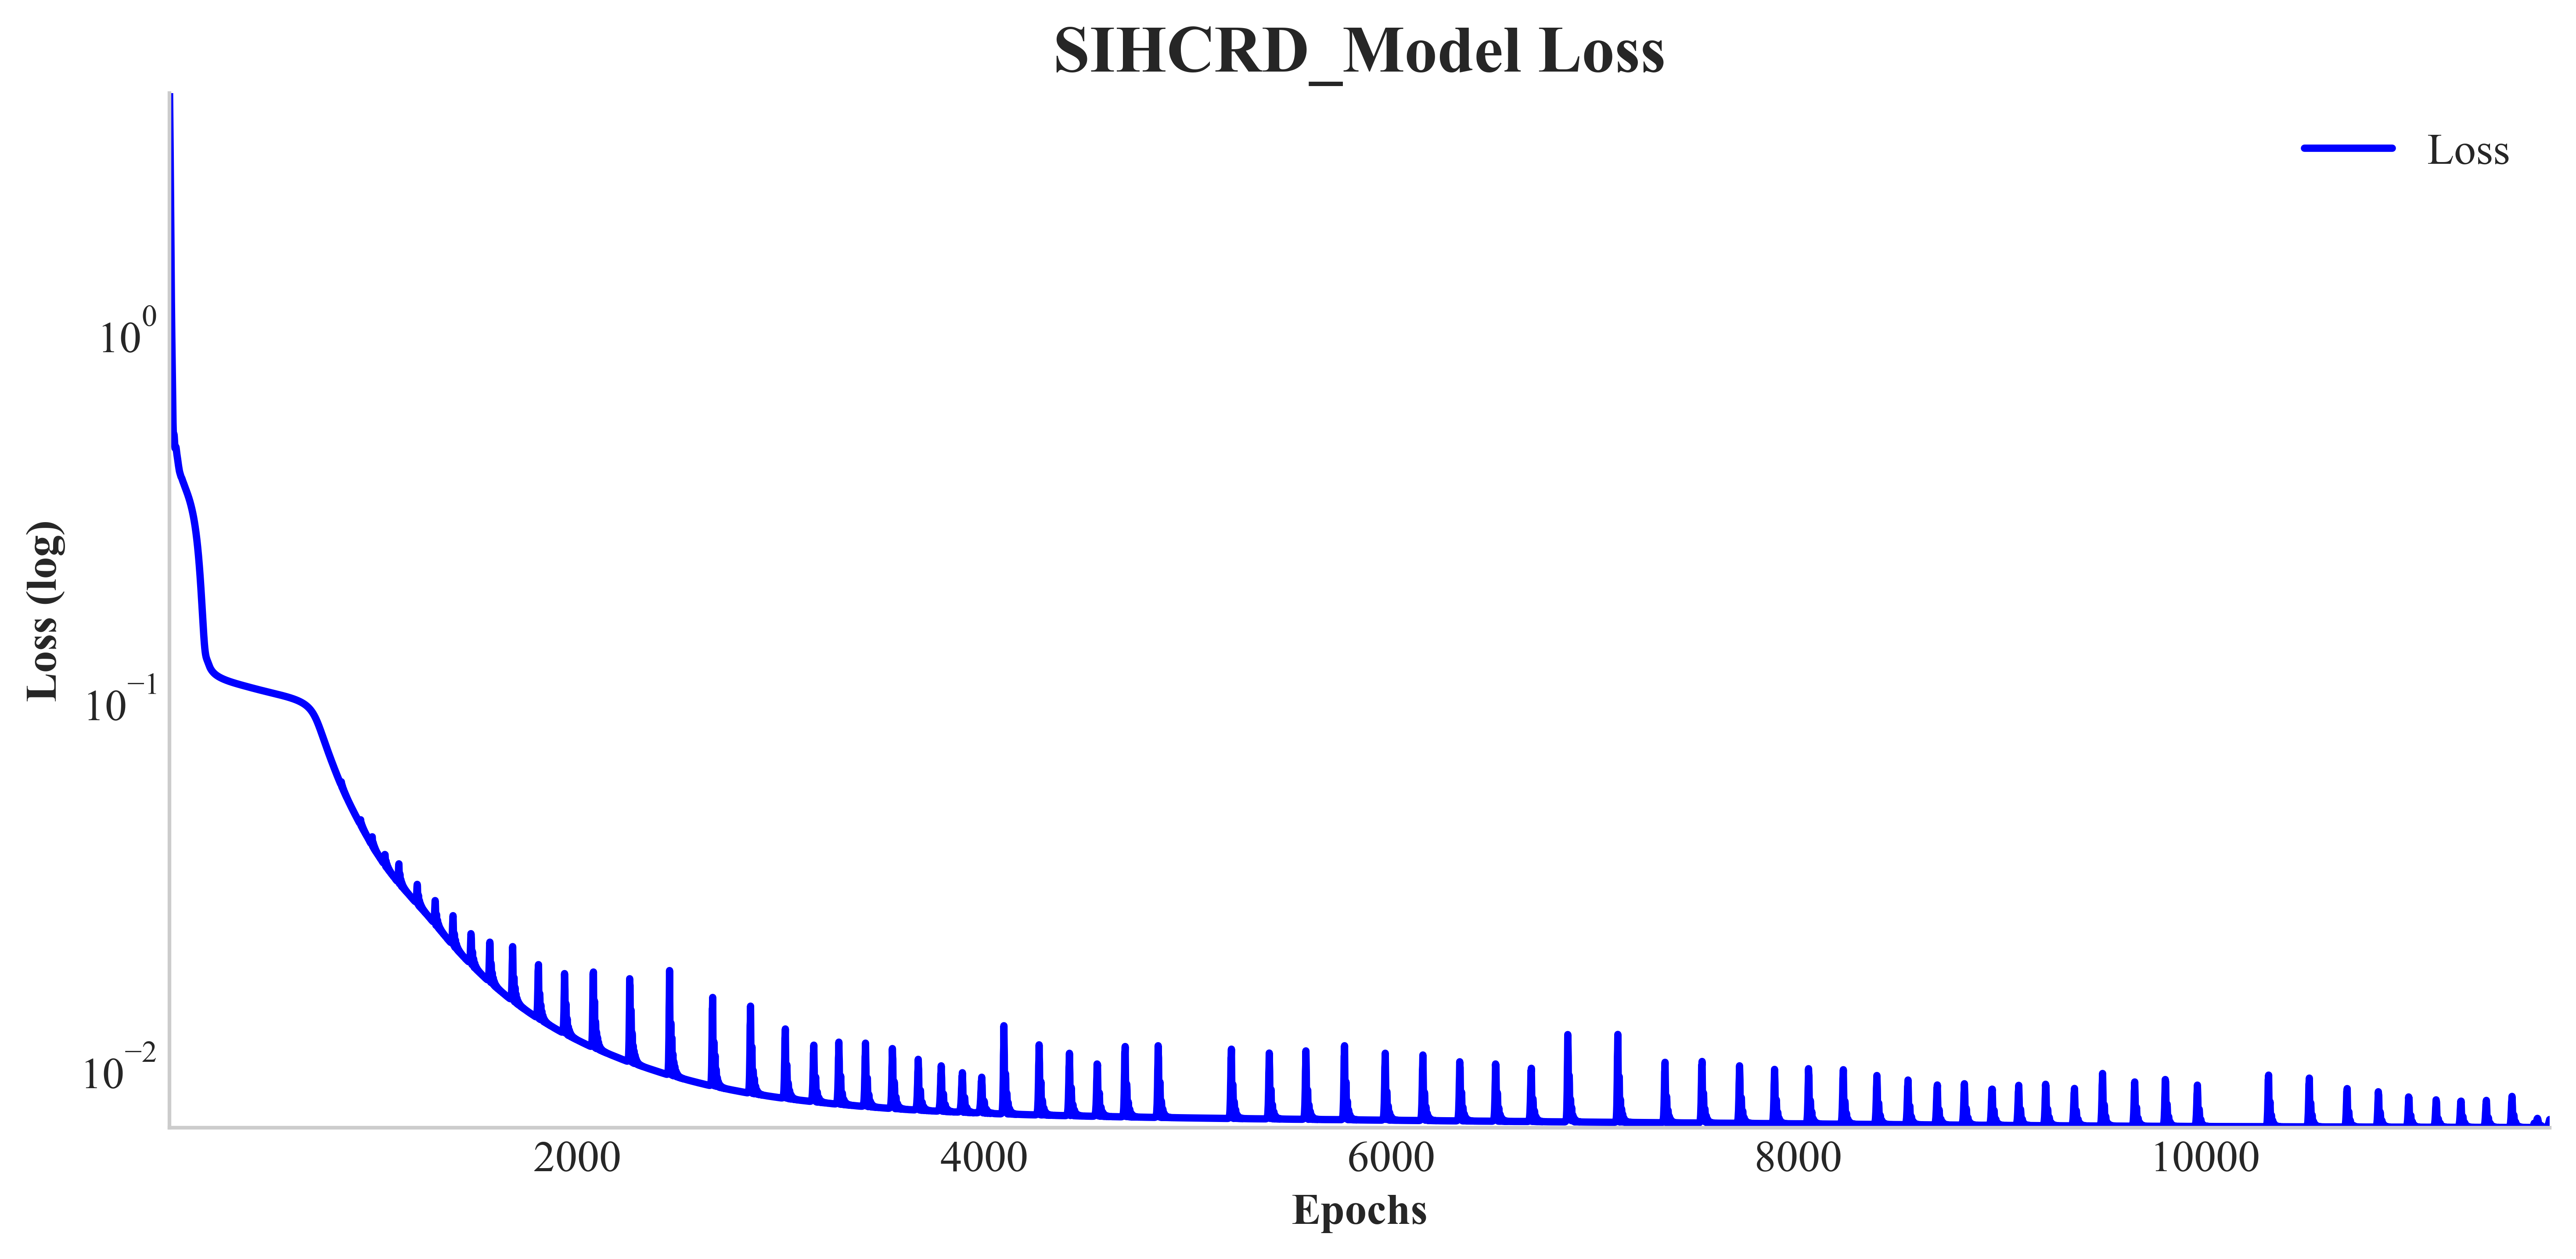

In [17]:
def plot_loss(
    losses,
    title,
    save_path="reports/figures",
    show=True,
    figsize=(10, 5),
    grid=True,
    save_format="pdf",
):
    """
    Enhanced plotting function for the training loss of a model, with logarithmic y-axis.

    Args:
    - losses (list or dict): A list of loss values per epoch, or a dictionary of lists for multiple loss components.
    - title (str): Title for the plot.
    - save_path (str, optional): Directory to save the plot. Default is "reports/figures".
    - show (bool, optional): Whether to display the plot. Default is True.
    - figsize (tuple, optional): Figure size. Default is (8, 5).
    - grid (bool, optional): Whether to show grid lines. Default is True.
    - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.

    Returns:
    None
    """
    
    # Logarithmic y-axis scale for the loss10 plot starting from epoch 1 (not 0) for better visualization and the x-axis starts from 0
    plt.figure(figsize=figsize)
    plt.plot(np.arange(1, len(losses) + 1), losses, label="Loss", color="blue")
    plt.yscale("log")
    plt.title(f"{title} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (log)")
    plt.legend()
    # plt.grid(grid)

    
    if save_path:
        plt.savefig(f"{save_path}/{title.replace(' ', '_')}_Loss_of_PINNs_log.{save_format}")
    if show:
        plt.show()
        
plot_loss(losses, "SIHCRD_Model")

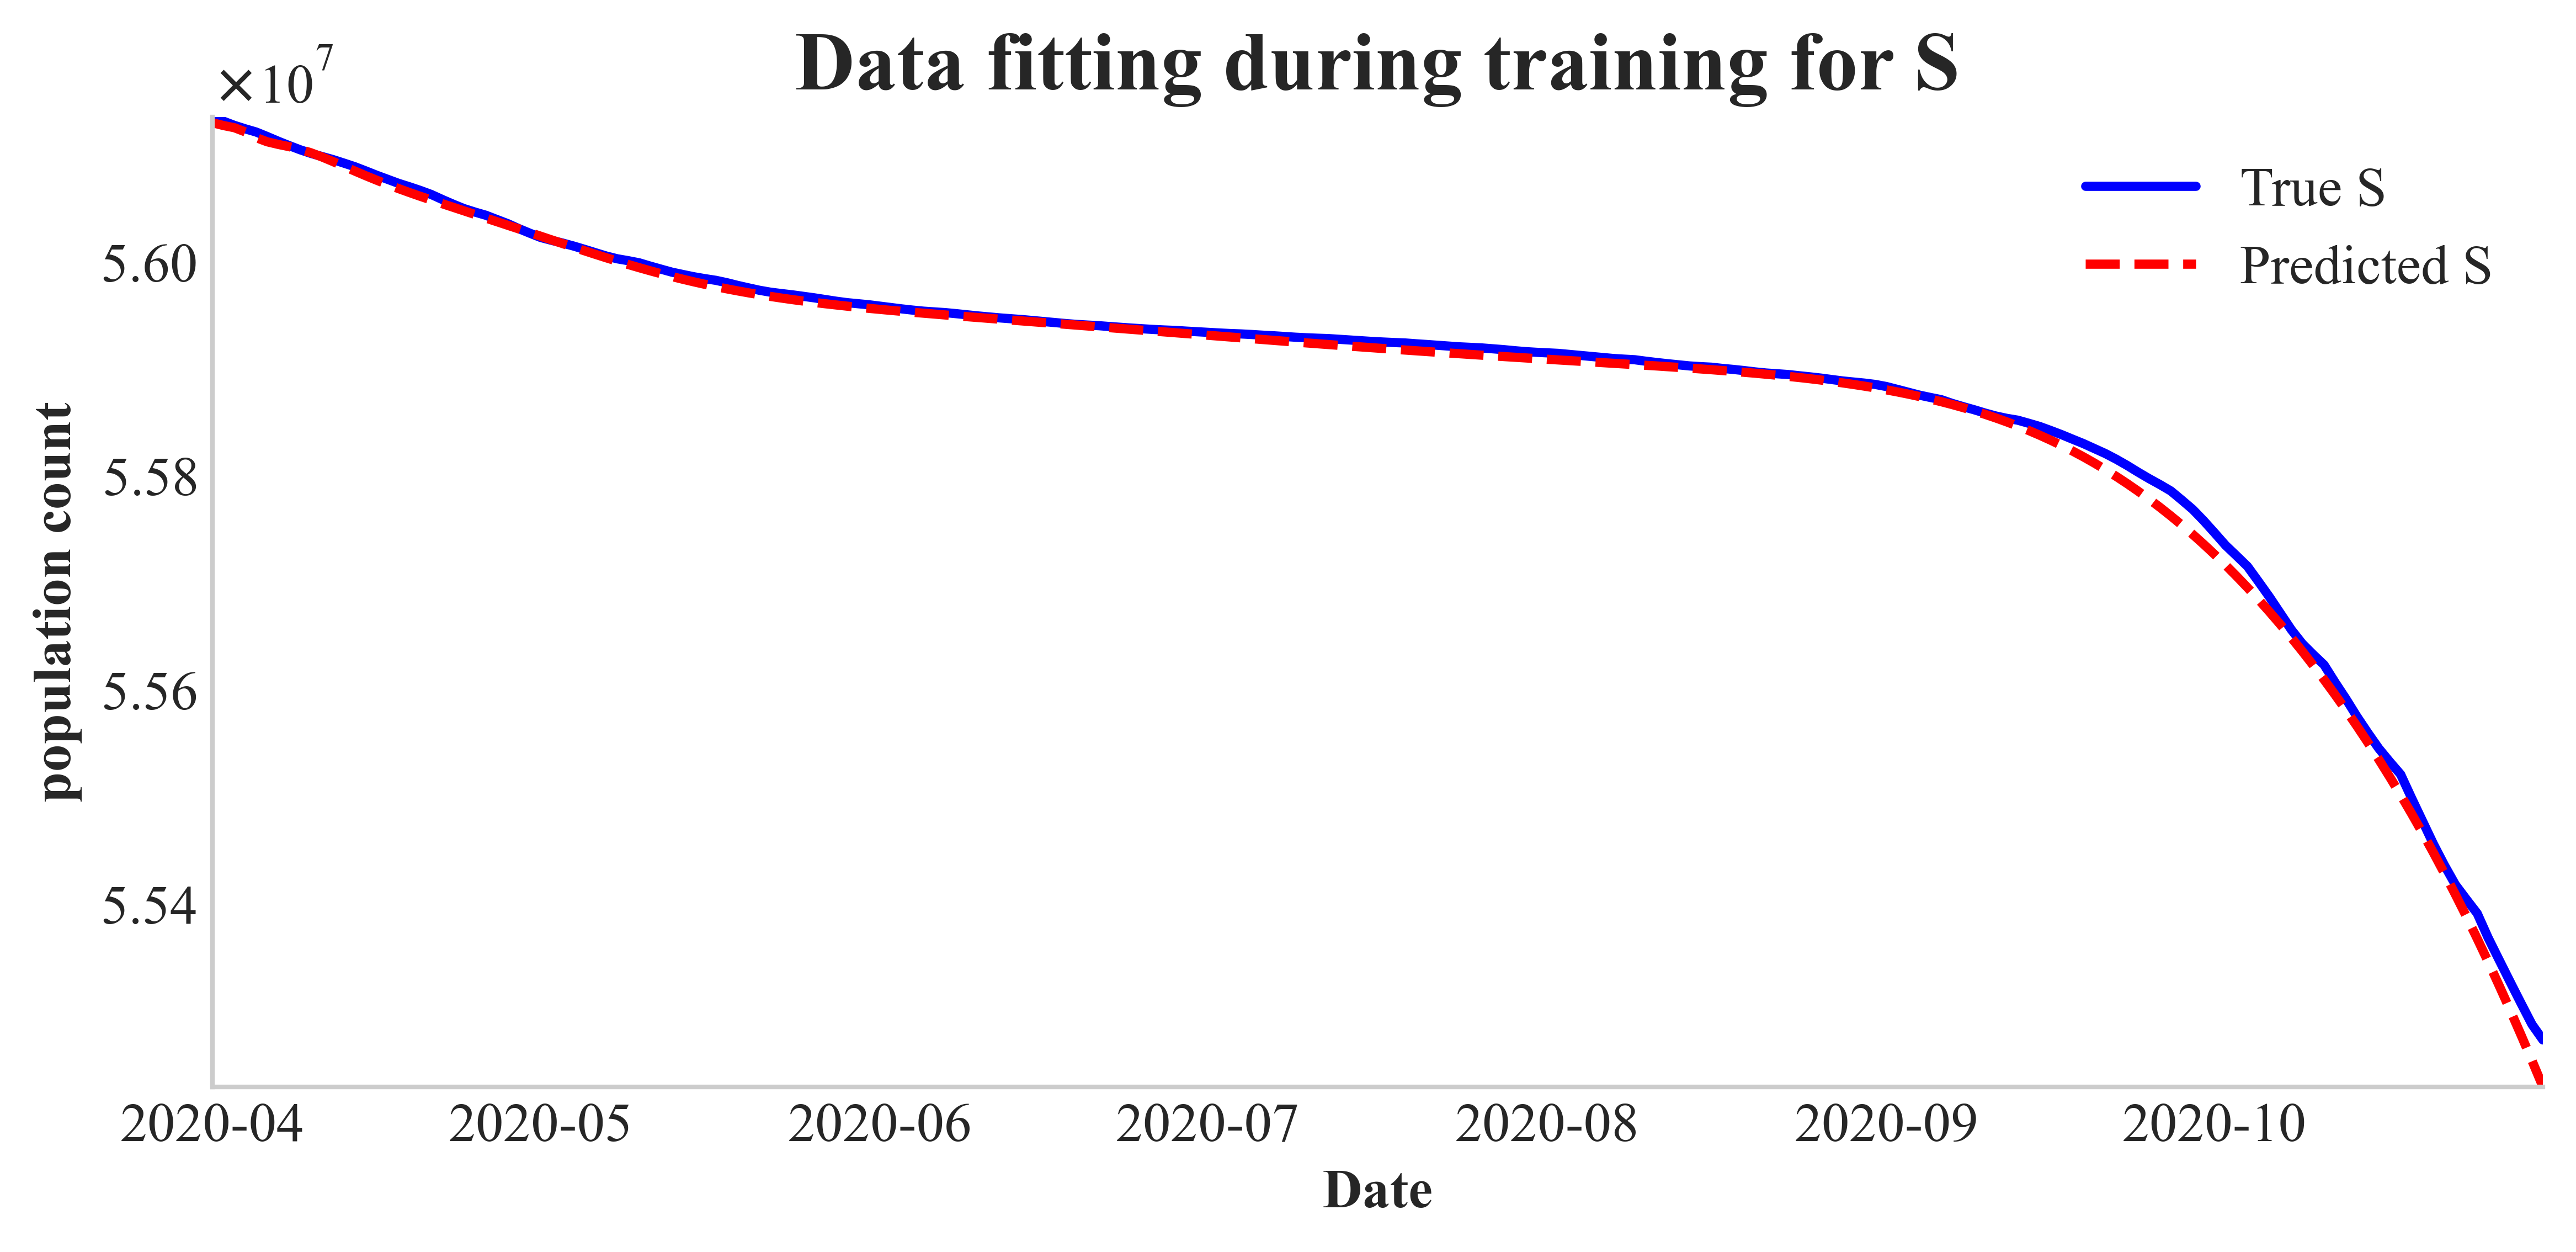

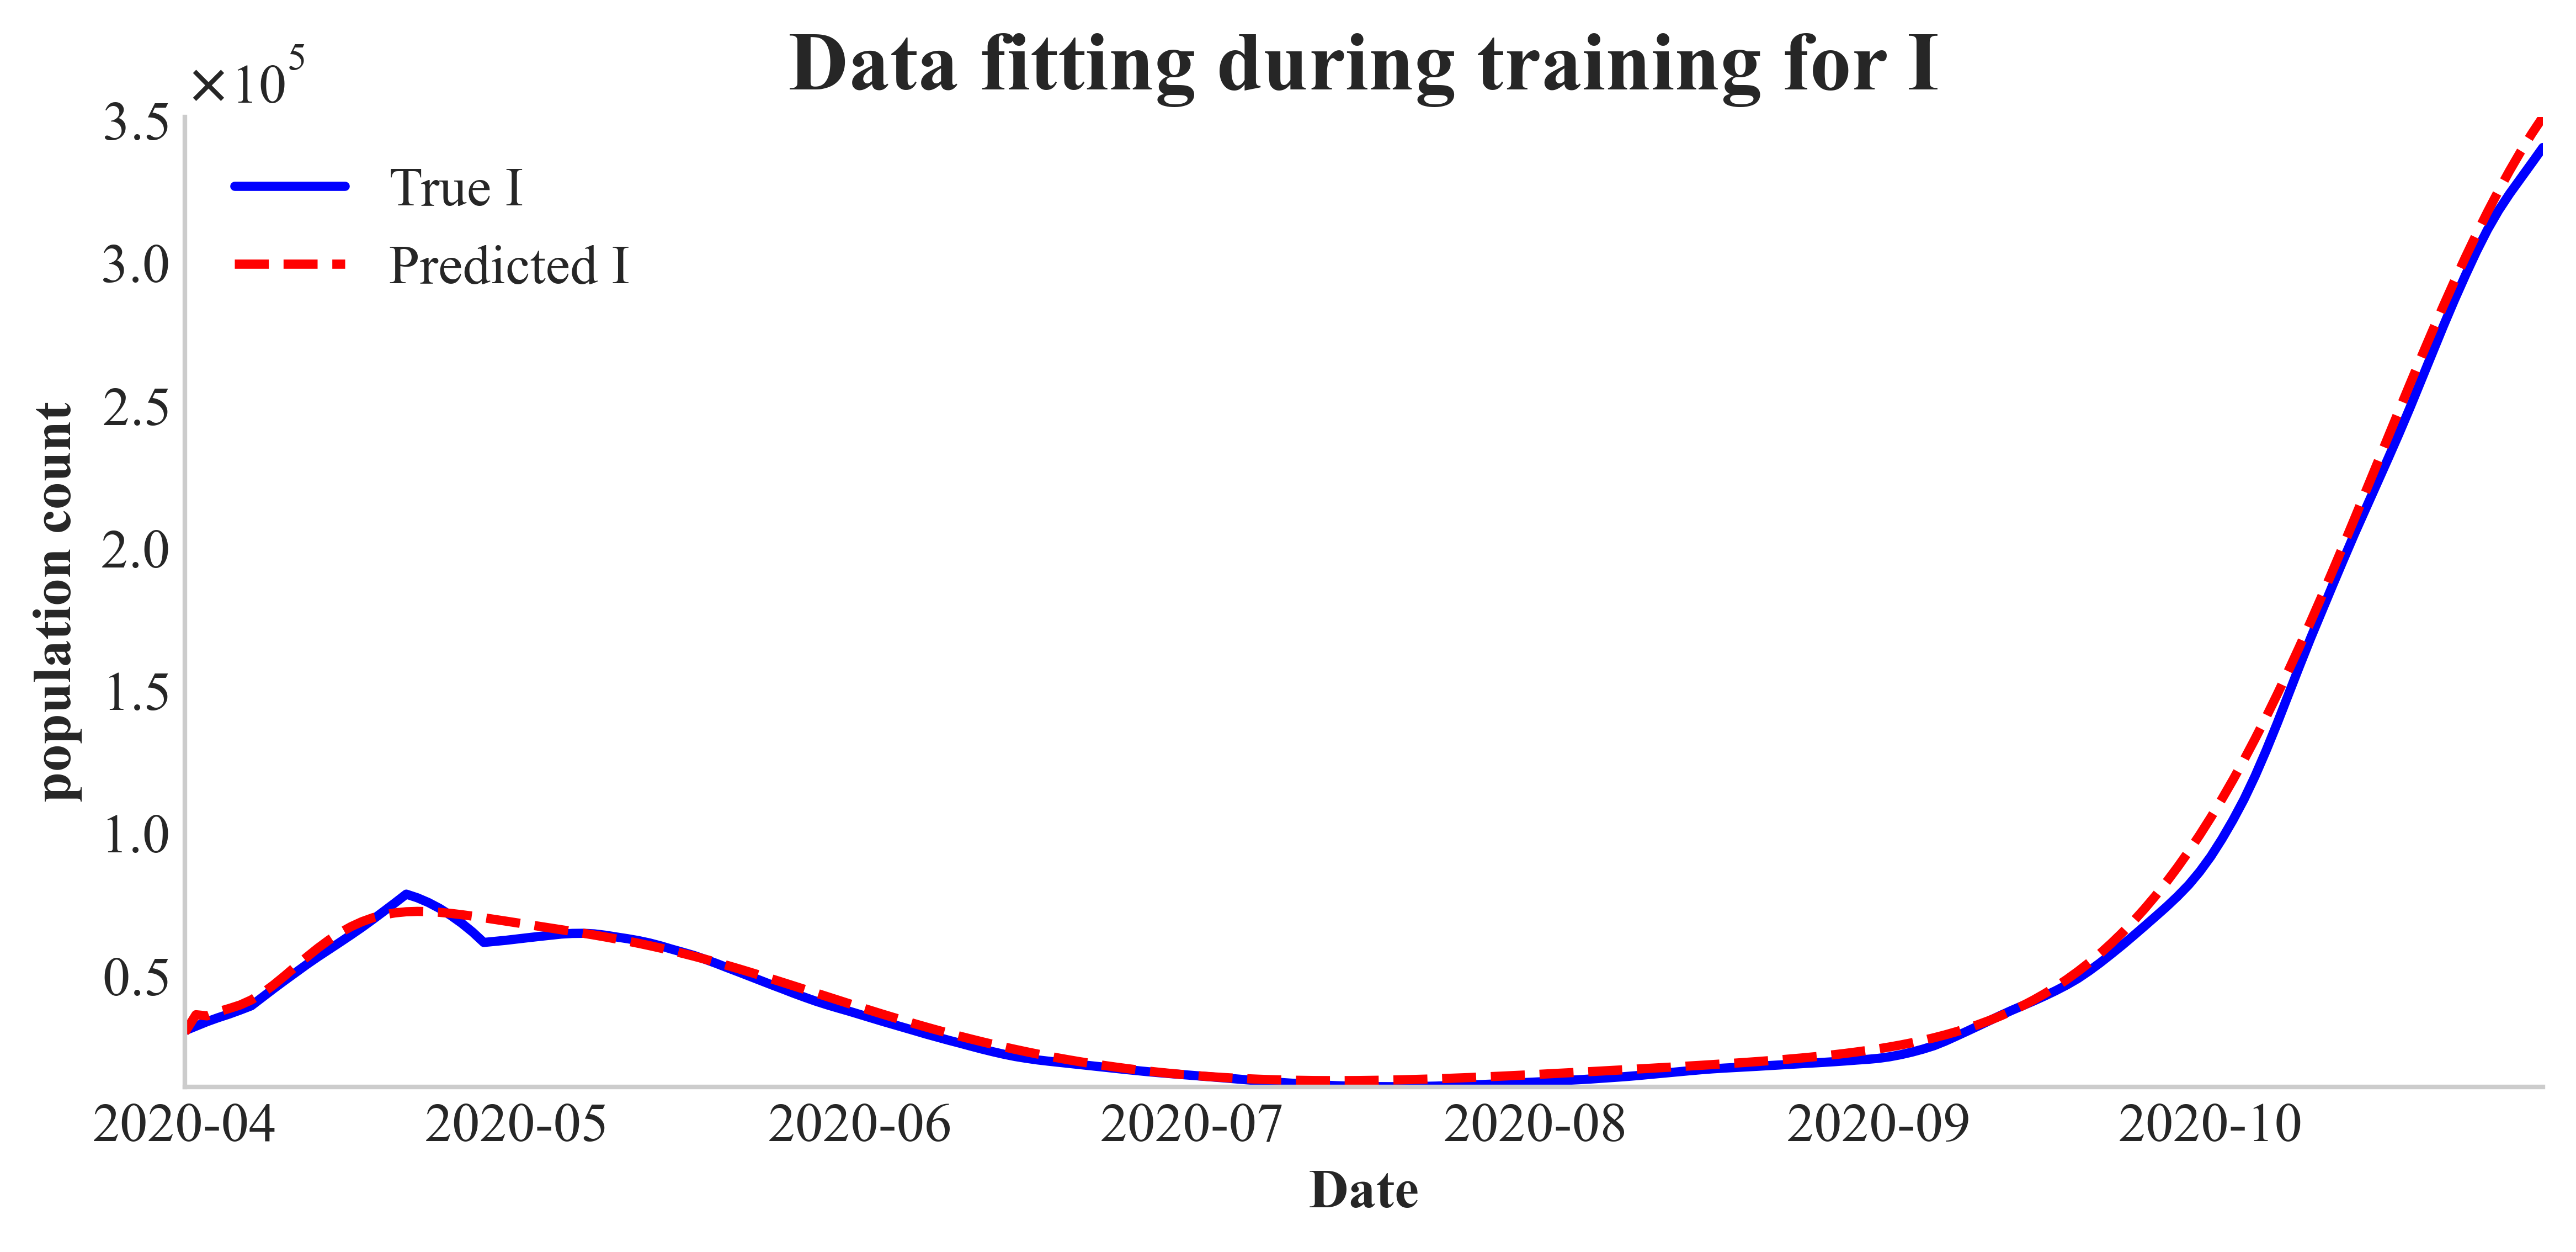

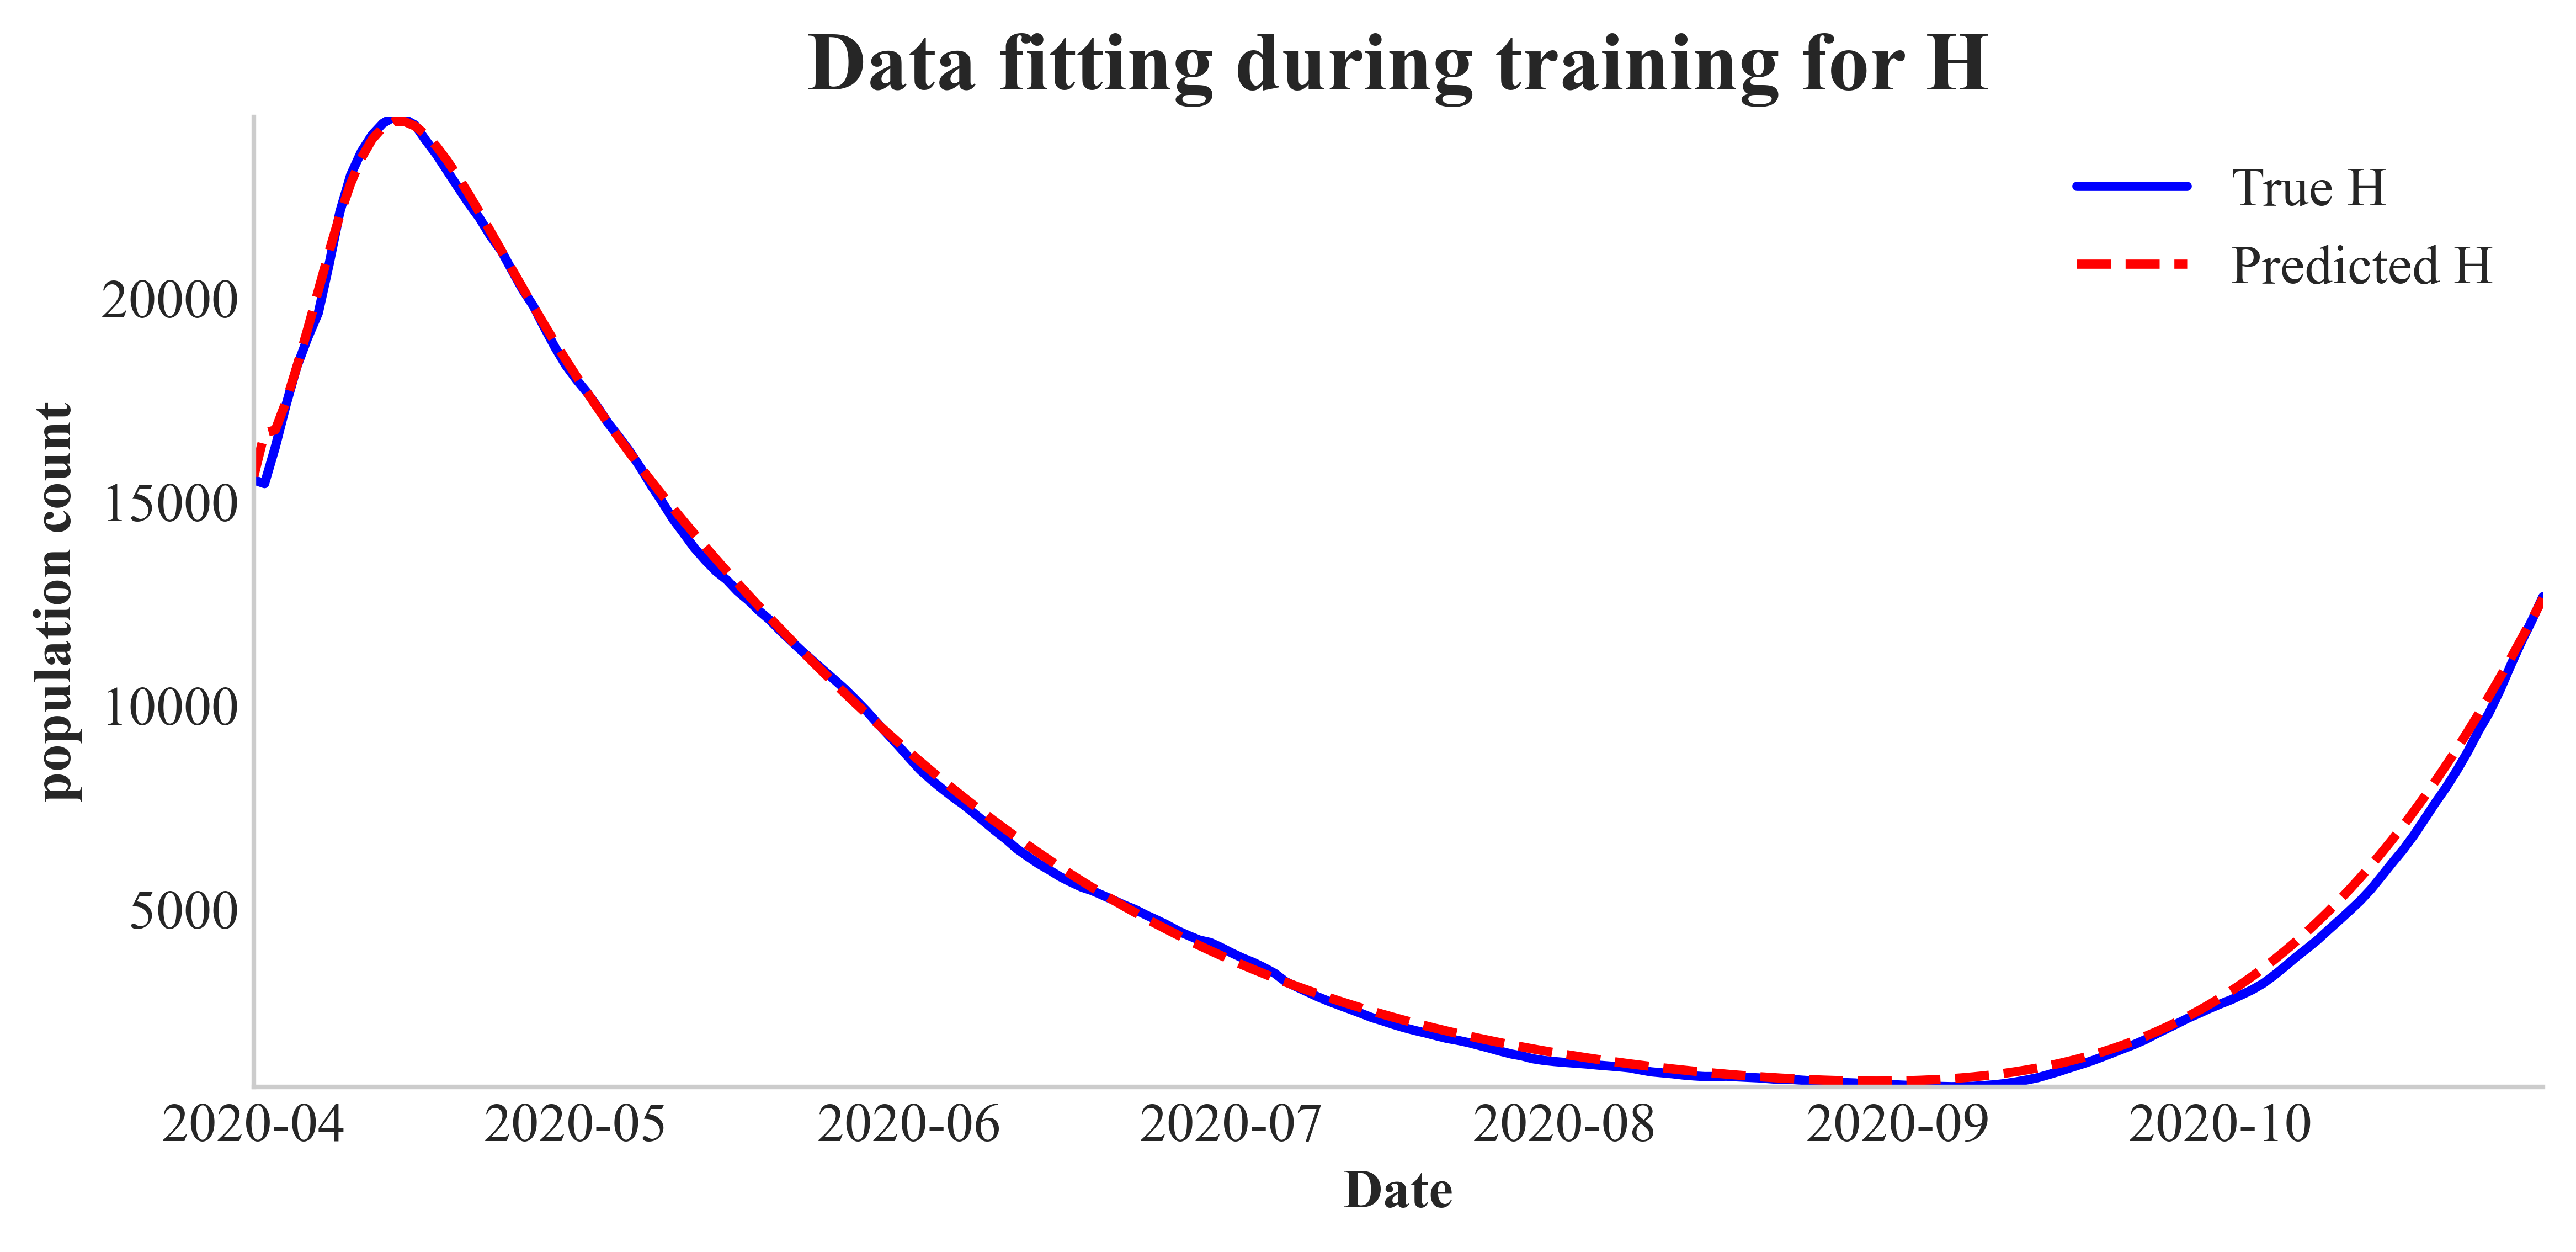

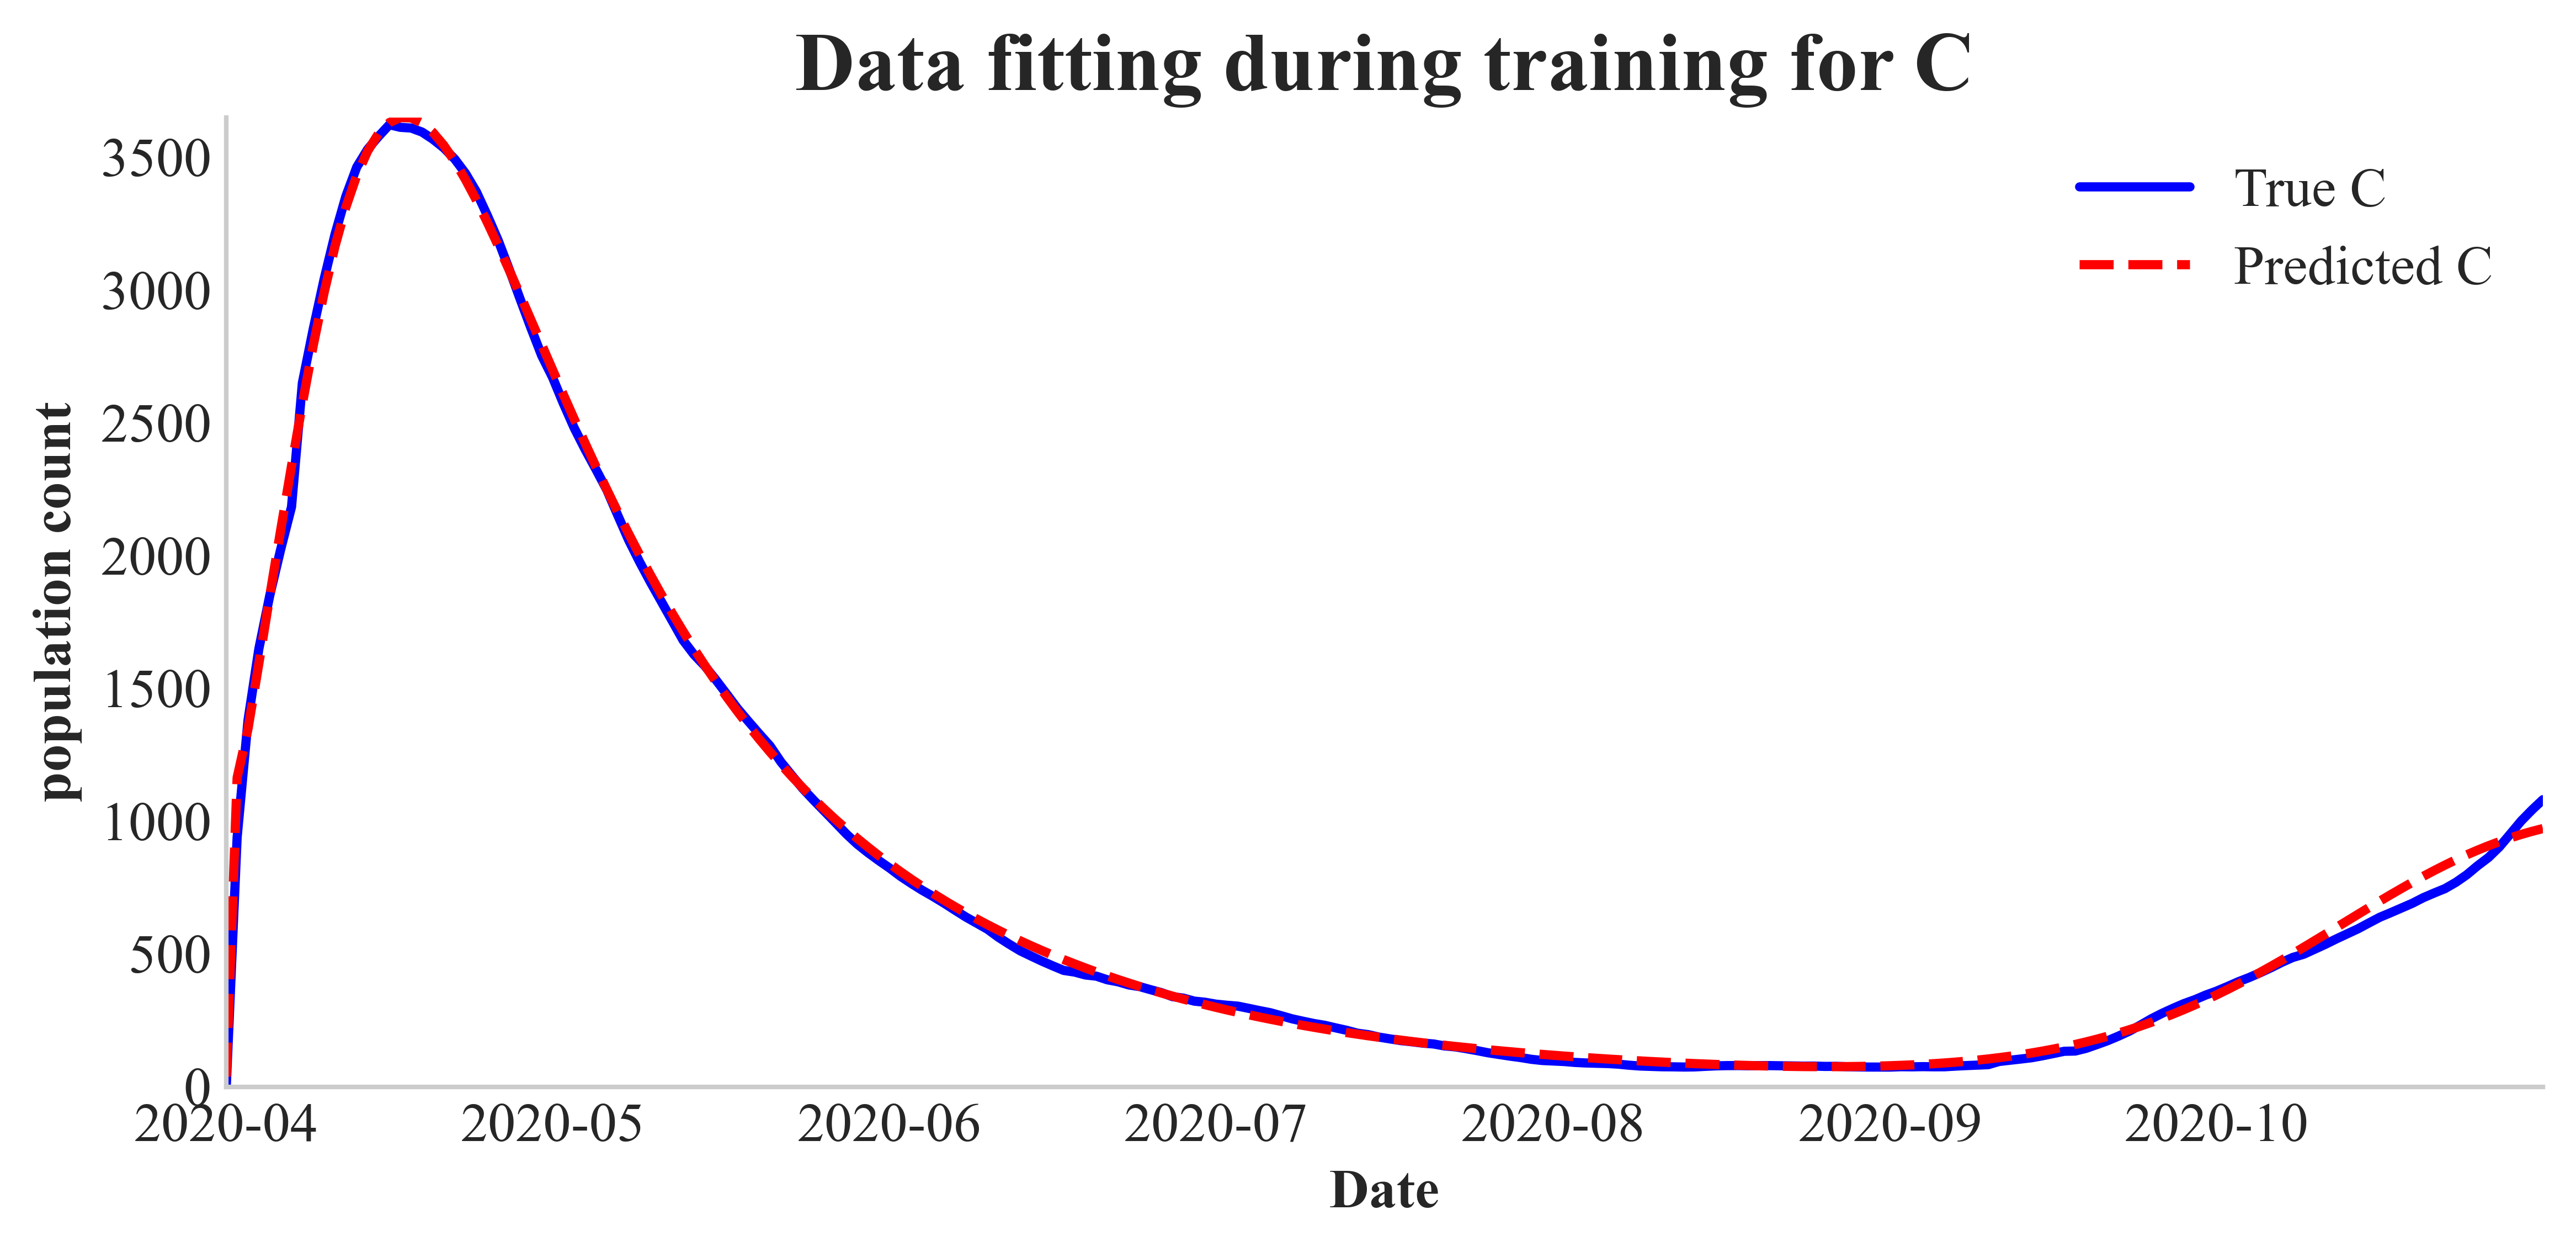

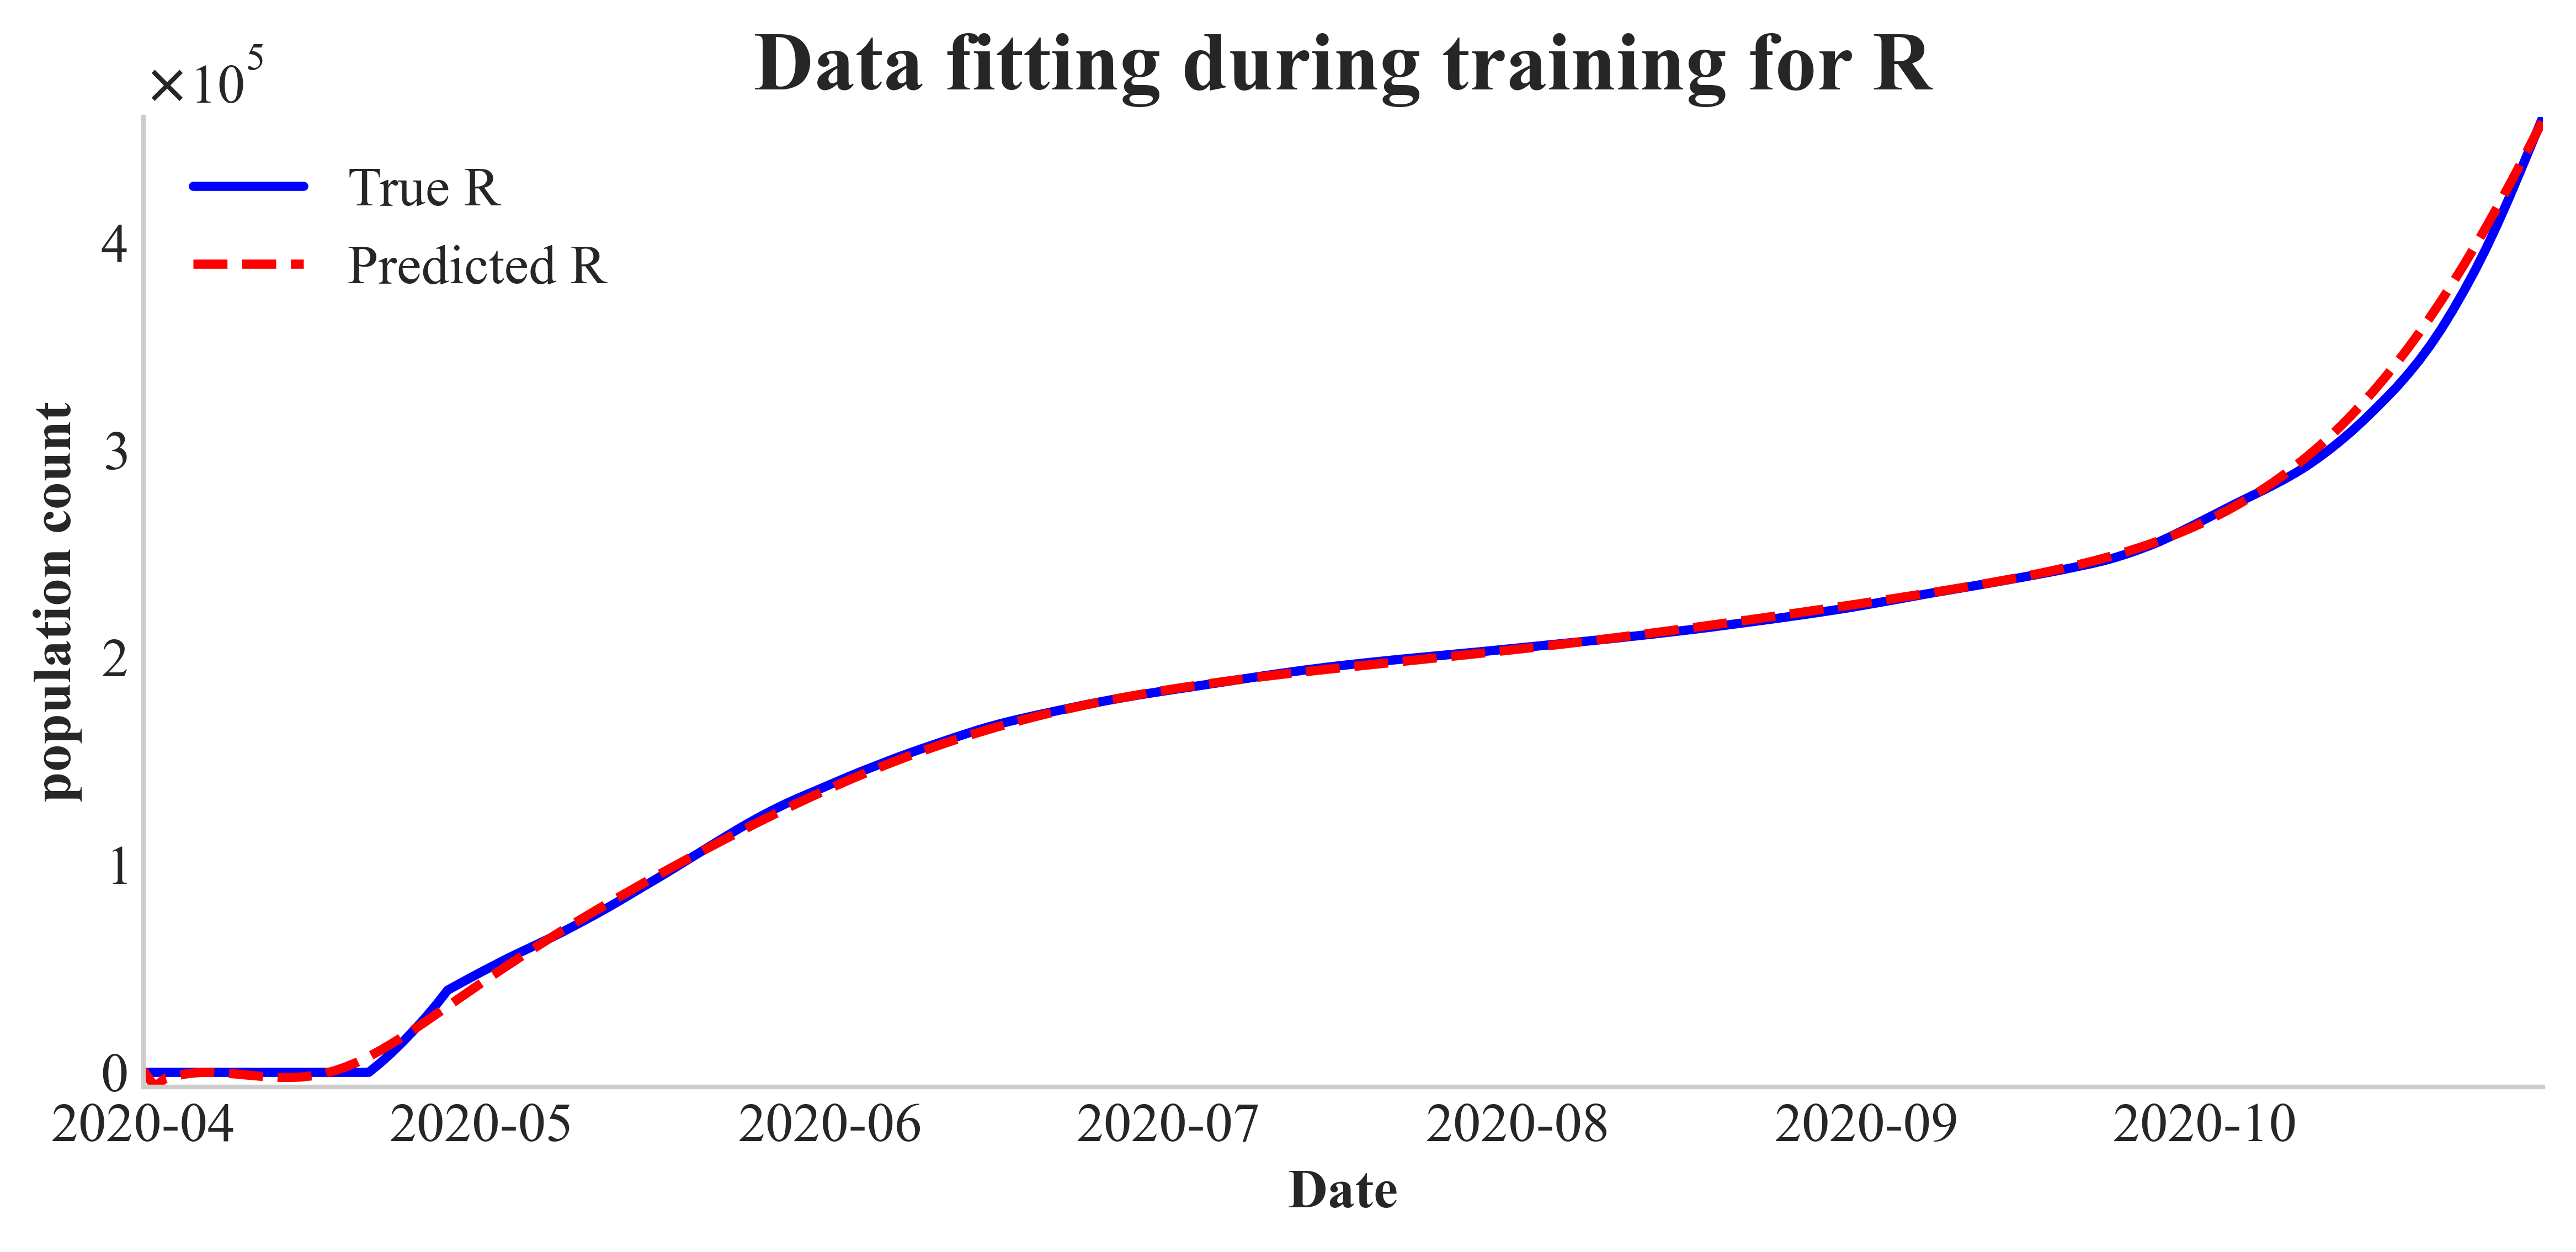

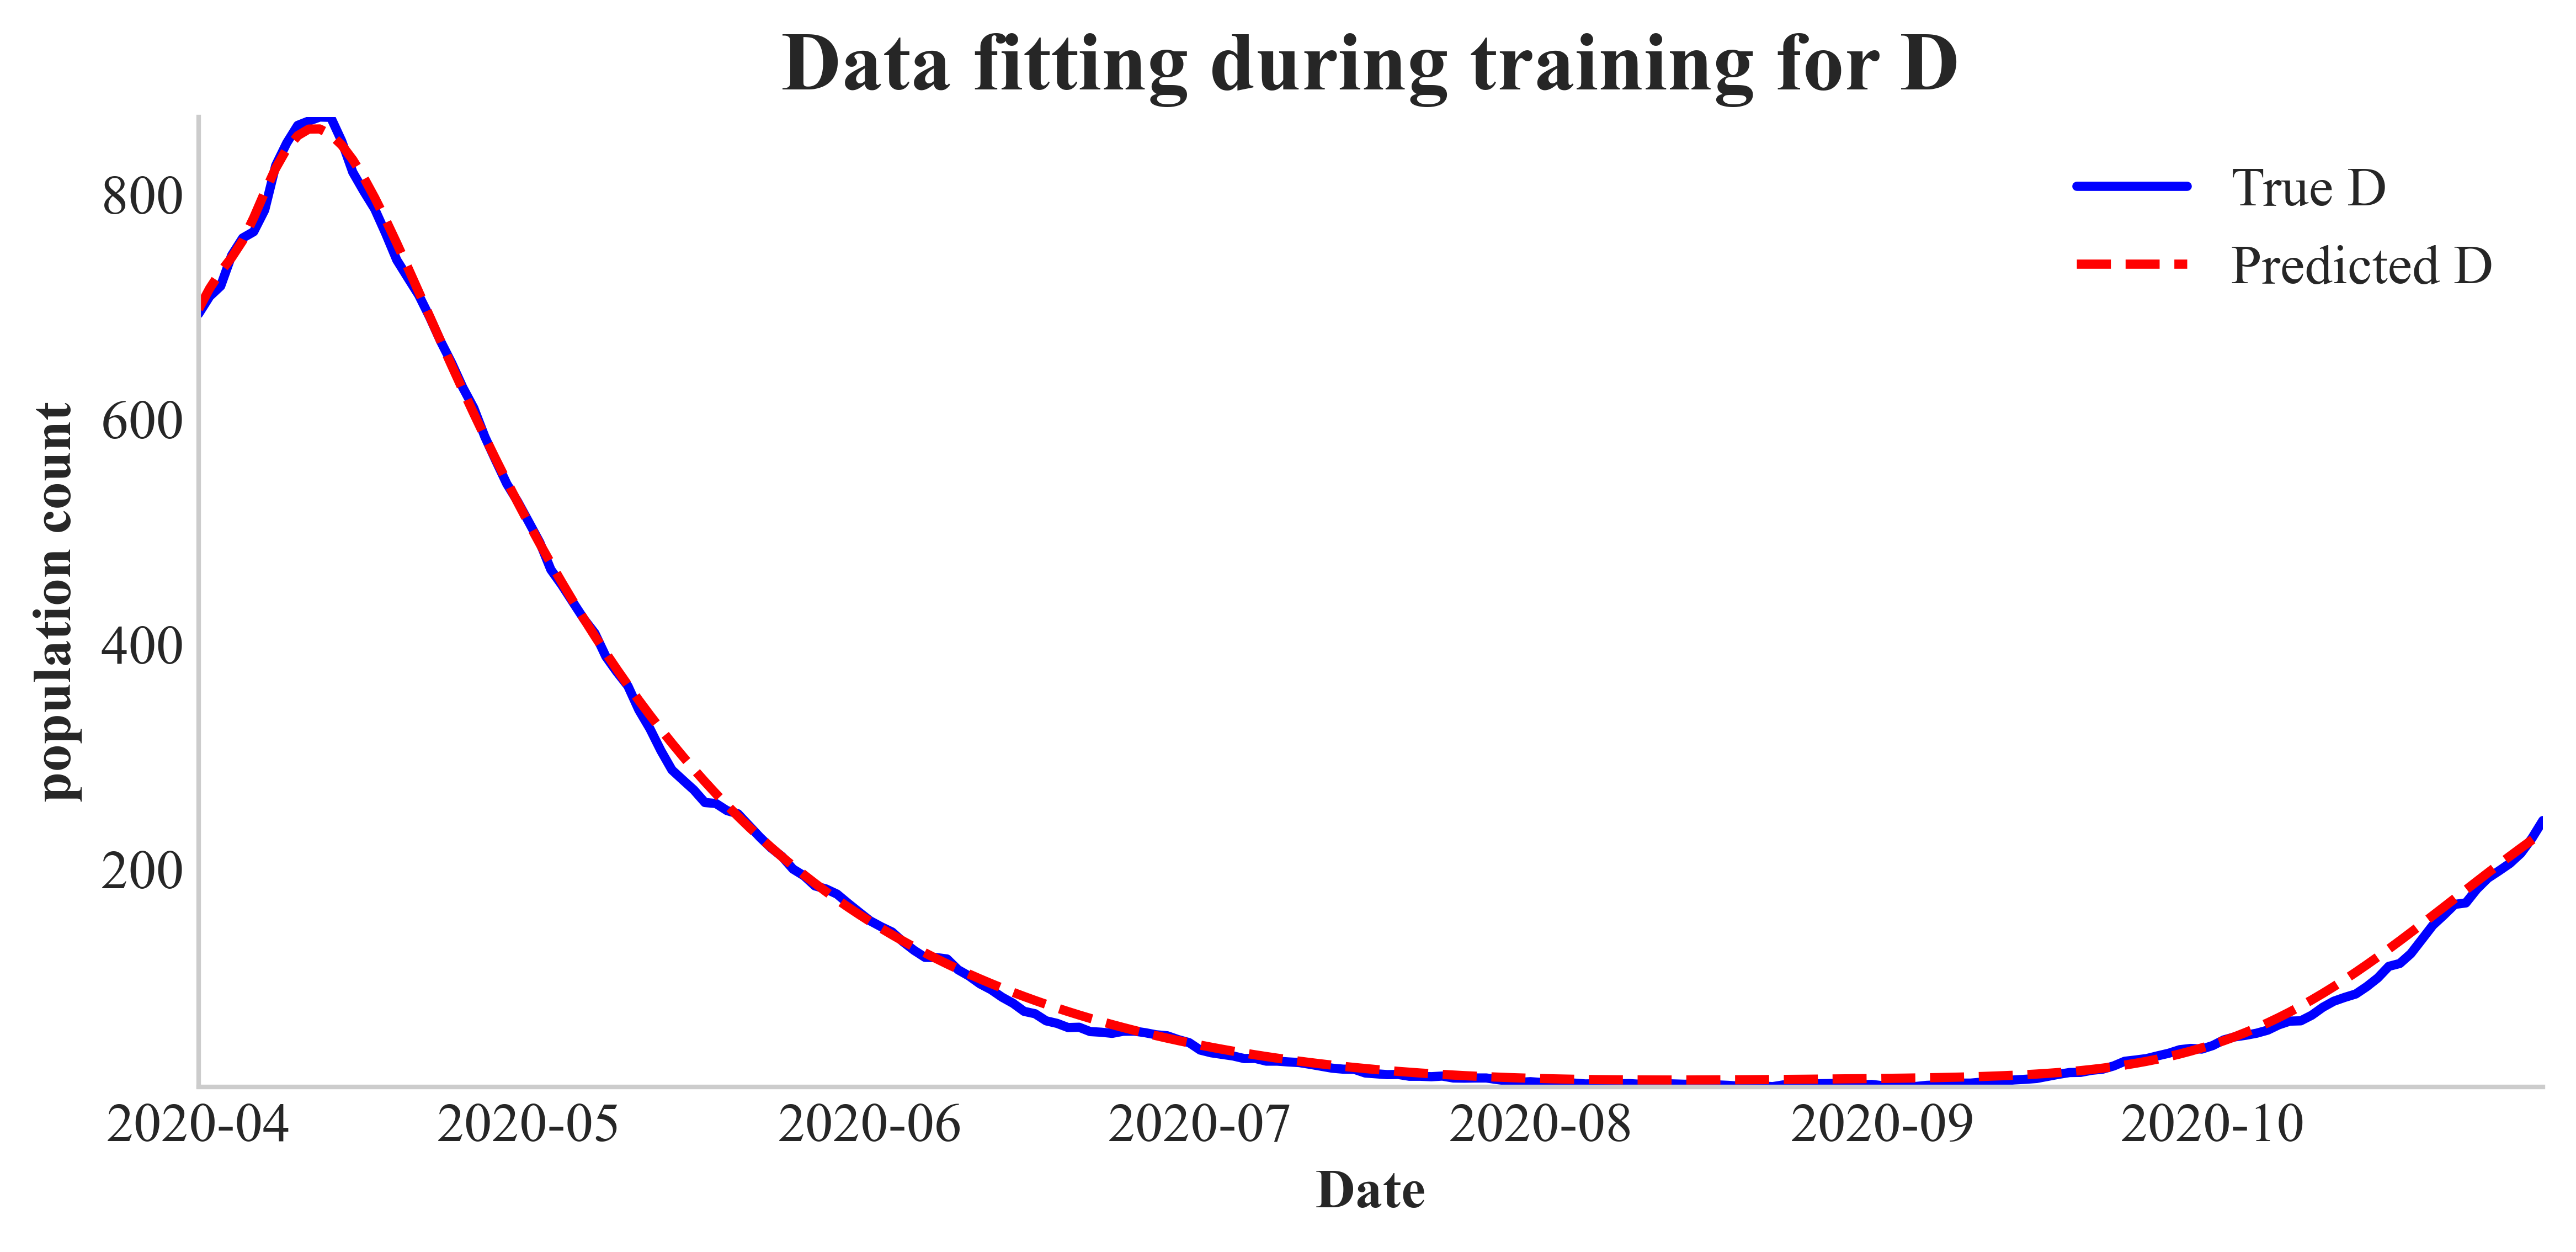

In [18]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(t_data).cpu()  # Move tensors to CPU for plotting

# Extract predictions into individual components
S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3], predictions[:, 4], predictions[:, 5]

# Extract true values from the tensor
S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor[:, 0], SIHCRD_tensor[:, 1], SIHCRD_tensor[:, 2], SIHCRD_tensor[:, 3], SIHCRD_tensor[:, 4], SIHCRD_tensor[:, 5]


# Ensure all tensors are on CPU before converting to NumPy arrays for scaling
S_pred = S_pred.cpu()
I_pred = I_pred.cpu()
H_pred = H_pred.cpu()
C_pred = C_pred.cpu()
R_pred = R_pred.cpu()
D_pred = D_pred.cpu()

S_true = S_true.cpu()
I_true = I_true.cpu()
H_true = H_true.cpu()
C_true = C_true.cpu()
R_true = R_true.cpu()
D_true = D_true.cpu()

# Prepare data for rescaling
rescaled_pred = scaler.inverse_transform(
    np.concatenate(
        [
            S_pred.view(-1, 1).numpy(),
            I_pred.view(-1, 1).numpy(),
            H_pred.view(-1, 1).numpy(),
            C_pred.view(-1, 1).numpy(),
            R_pred.view(-1, 1).numpy(),
            D_pred.view(-1, 1).numpy(),
        ],
        axis=1,
    )
)

rescaled_true = scaler.inverse_transform(
    np.concatenate(
        [
            S_true.view(-1, 1).numpy(),
            I_true.view(-1, 1).numpy(),
            H_true.view(-1, 1).numpy(),
            C_true.view(-1, 1).numpy(),
            R_true.view(-1, 1).numpy(),
            D_true.view(-1, 1).numpy(),
        ],
        axis=1,
    )
)


# Extract rescaled for all compartments and plot individual plots
S_pred_rescaled, I_pred_rescaled, H_pred_rescaled, C_pred_rescaled, R_pred_rescaled, D_pred_rescaled = rescaled_pred[:, 0], rescaled_pred[:, 1], rescaled_pred[:, 2], rescaled_pred[:, 3], rescaled_pred[:, 4], rescaled_pred[:, 5]

S_true_rescaled, I_true_rescaled, H_true_rescaled, C_true_rescaled, R_true_rescaled, D_true_rescaled = rescaled_true[:, 0], rescaled_true[:, 1], rescaled_true[:, 2], rescaled_true[:, 3], rescaled_true[:, 4], rescaled_true[:, 5]

# Plot the rescaled predictions and true values for each compartment on a different plot
# Generate plots for each component
for i, comp in enumerate(["S", "I", "H", "C", "R", "D"]):
    plt.figure(figsize=(8, 4))
    plt.plot(data["date"], rescaled_true[:, i], label=f"True {comp}", color="blue", linewidth=2)
    plt.plot(data["date"], rescaled_pred[:, i], label=f"Predicted {comp}", linestyle="--", color="red", linewidth=2)
    plt.title(f"Data fitting during training for {comp}")
    plt.xlabel("Date")
    plt.ylabel("population count")
    plt.legend()
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"reports/figures/SIHCRD_{comp}_Predicted_vs_True.pdf")
    plt.show()


In [19]:
rescaled_pred

array([[ 5.6130408e+07,  3.0228602e+04,  1.5636352e+04,  3.7941845e+01,
         8.6182941e+02,  6.9828943e+02],
       [ 5.6127804e+07,  3.6438535e+04,  1.6700449e+04,  1.1633892e+03,
        -6.9151592e+03,  7.1656110e+02],
       [ 5.6125748e+07,  3.6043648e+04,  1.6771633e+04,  1.3474614e+03,
        -2.6316294e+03,  7.3147638e+02],
       ...,
       [ 5.5278020e+07,  3.3917834e+05,  1.1643402e+04,  9.4966498e+02,
         4.3770844e+05,  2.1880782e+02],
       [ 5.5254112e+07,  3.4543838e+05,  1.2134961e+04,  9.6140210e+02,
         4.4820003e+05,  2.2592944e+02],
       [ 5.5229688e+07,  3.5127744e+05,  1.2636867e+04,  9.7196722e+02,
         4.5891166e+05,  2.3290892e+02]], dtype=float32)

In [20]:
# Extract the time varying learnable parameters and plot them over time
beta = model.beta.cpu().detach().numpy()
mu = model.mu.cpu().detach().numpy()
delta = model.delta.cpu().detach().numpy()
xi = model.xi.cpu().detach().numpy()

# create a dataframe of the estimated paramter values
params_df = pd.DataFrame(
    {
        "beta": beta,
        "mu": mu,
        "delta": delta,
        "xi": xi,
    }
)

params_df.head()

,beta,mu,delta,xi
0,0.117592,-0.002114,-0.110819,0.084881


In [21]:
def forecast_using_nn(model, initial_conditions, days, device):
    model.eval()
    forecasts = []
    current_state = torch.tensor(initial_conditions, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        for _ in range(days):
            next_state = model(current_state)
            current_state = next_state
            forecasts.append(next_state.squeeze(0).cpu().numpy())

    return np.array(forecasts)

In [22]:
# Get the last available scaled data point as initial conditions for forecasting
initial_conditions = np.array([S_pred[-1], I_pred[-1], H_pred[-1], C_pred[-1], R_pred[-1], D_pred[-1]]).flatten()

# Forecast for a specified number of days
days_to_forecast = 14  # You can adjust this number based on your needs
forecasted_values = forecast_using_nn(model, initial_conditions, days_to_forecast, device)

# Inverse scaling the forecasted values to match the original data scale
forecasted_values = scaler.inverse_transform(forecasted_values)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 1x32)

In [ ]:
# 7 days prediction from the end of training using odeint
from scipy.integrate import odeint

def sihcrd_odeint(y, t, alpha, sigma, beta, gamma, theta, N, rho, delta, eta, kappa, mu, xi):
    S, I, H, C, R, D = y
    dSdt = -(beta * I / N) * S
    dIdt = (beta * S / N) * I - (gamma + rho + delta) * I
    dHdt = rho * I - (eta + kappa) * H
    dCdt = eta * H - (mu + xi) * C
    dRdt = gamma * I + kappa * H + mu * C
    dDdt = delta * I + xi * C
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [params["N"] - 1, 1, 0, 0, 0, 0]

# Time points for prediction
days = 7

# Time points for prediction
t_pred = np.arange(0, days, 1)

# Solve the ODEs using odeint
y_pred = odeint(
    sihcrd_odeint,
    initial_conditions,
    t_pred,
    args=(
        params["alpha"],
        params["sigma"],
        beta,
        params["gamma"],
        params["theta"],
        params["N"],
        params["rho"],
        params["delta"],
        params["eta"],
        params["kappa"],
        params["mu"],
        params["xi"],
    ),
)

# Extract the predicted values for each compartment
S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3], y_pred[:, 4], y_pred[:, 5]

# Plot the predicted values for each compartment
plt.figure(figsize=(10, 5))
plt.plot(t_pred, S_pred, label="Predicted S", color="blue")
plt.plot(t_pred, I_pred, label="Predicted I", color="red")
plt.plot(t_pred, H_pred, label="Predicted H", color="green")
plt.plot(t_pred, C_pred, label="Predicted C", color="purple")
plt.plot(t_pred, R_pred, label="Predicted R", color="orange")
plt.plot(t_pred, D_pred, label="Predicted D", color="brown")
plt.title("7-day prediction using ODEINT for SIHCRD model")
plt.xlabel("Days")
plt.ylabel("Population count")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("reports/figures/SIHCRD_7_day_prediction.pdf")
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [ ]:
# fit the results to the ODE model and forecast the future, for the next 7 days and 14 days and lot the results
def fit_ode_model(
    model,
    t_data,
    N,
    initial_conditions,
    scaler,
    device,
    forecast_days=14,
):
    """
    Fit the learned parameters to the ODE model and forecast the future.

    Args:
    - model (nn.Module): The trained model.
    - t_data (torch.Tensor): The time tensor.
    - N (int): The total population.
    - initial_conditions (list): The initial conditions.
    - scaler (MinMaxScaler): The fitted scaler object.
    - device (torch.device): The device to use.
    - forecast_days (int): The number of days to forecast. Default is 14.

    Returns:
    - tuple: A tuple of the forecasted values and the time tensor.
    """
    # Extract the learned parameters
    beta = model.beta.cpu().detach().numpy()
    mu = model.mu.cpu().detach().numpy()
    delta = model.delta.cpu().detach().numpy()
    xi = model.xi.cpu().detach().numpy()
    
    # Initialize the SIHCRD model
    def sihcrd_model(t, y, params):
        S, I, H, C, R, D = y
        N = params["N"]
        beta = params["beta"]
        gamma = 0.125
        rho = 0.03
        delta = 0.02
        eta = 0.125
        kappa = 0.01875
        mu = 0.14
        xi = 0.143

        S = N - sum(y)  # Recompute S based on other compartments
        dSdt = -(beta * I / N) * S
        dIdt = (beta * S / N) * I - (gamma + rho + delta) * I
        dHdt = rho * I - (eta + kappa) * H
        dCdt = eta * H - (mu + xi) * C
        dRdt = gamma * I + kappa * H + mu * C
        dDdt = delta * I + xi * C
        return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]
    
    # Integrate the model using the learned parameters
    solution = solve_ivp(
        sihcrd_model,
        [t_data[0], t_data[-1] + forecast_days],
        initial_conditions,
        args=({"N": N, "beta": beta, "mu": mu, "delta": delta, "xi": xi}),
        t_eval=t_data,
    )
    
    # Extract the forecasted values
    S_forecast, I_forecast, H_forecast, C_forecast, R_forecast, D_forecast = solution.y
    
    # Inverse transform the forecasted values
    forecasted_values = scaler.inverse_transform(
        np.concatenate(
            [
                S_forecast.reshape(-1, 1),
                I_forecast.reshape(-1, 1),
                H_forecast.reshape(-1, 1),
                C_forecast.reshape(-1, 1),
                R_forecast.reshape(-1, 1),
                D_forecast.reshape(-1, 1),
            ],
            axis=1,
        )
    )
    
    return forecasted_values, solution.t

# Forecast the future for the next 14 days
forecasted_values, forecasted_t = fit_ode_model(
    model,
    t_data,
    params["N"],
    initial_conditions,
    scaler,
    device,
    forecast_days=14,
)

# Create a DataFrame of the forecasted values
forecasted_df = pd.DataFrame(
    forecasted_values,
    columns=["S", "I", "H", "C", "R", "D"],
    index=pd.date_range(start=data["date"].min(), periods=len(forecasted_values), freq="D"),
)

forecasted_df.head()

# Plot the forecasted values for each compartment
for i, comp in enumerate(["S", "I", "H", "C", "R", "D"]):
    plt.figure(figsize=(10, 5))
    plt.plot(data["date"], data[comp], label=f"True {comp}", color="blue", linewidth=2)
    plt.plot(forecasted_df.index, forecasted_df[comp], label=f"Forecasted {comp}", linestyle="--", color="red", linewidth=2)
    plt.title(f"Forecasting for {comp} for the next 14 days")
    plt.xlabel("Date")
    plt.ylabel("population count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"reports/figures/SIHCRD_{comp}_Forecasted.pdf")
    plt.show()
    
    


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# uncertainity quantification 95% confidence interval
from scipy import stats



def get_confidence_interval(predictions, alpha=0.05):
    """
    Compute the confidence interval for the model predictions.

    Args:
    - predictions (np.array): Array of model predictions.
    - alpha (float): Significance level for the confidence interval.

    Returns:
    - tuple: Lower and upper bounds of the confidence interval.
    """
    n = len(predictions)
    mean = np.mean(predictions)
    se = np.std(predictions) / np.sqrt(n)
    z = stats.norm.ppf(1 - alpha / 2)
    lower = mean - z * se
    upper = mean + z * se
    return lower, upper

# Extract the predictions for each compartment
S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = rescaled_pred[:, 0], rescaled_pred[:, 1], rescaled_pred[:, 2], rescaled_pred[:, 3], rescaled_pred[:, 4], rescaled_pred[:, 5]

# Compute the confidence intervals for each compartment
S_lower, S_upper = get_confidence_interval(S_pred)
I_lower, I_upper = get_confidence_interval(I_pred)
H_lower, H_upper = get_confidence_interval(H_pred)
C_lower, C_upper = get_confidence_interval(C_pred)
R_lower, R_upper = get_confidence_interval(R_pred)
D_lower, D_upper = get_confidence_interval(D_pred)

# Create a DataFrame for the confidence intervals
confidence_intervals = pd.DataFrame(
    {
        "Compartment": ["S", "I", "H", "C", "R", "D"],
        "Lower Bound": [S_lower, I_lower, H_lower, C_lower, R_lower, D_lower],
        "Upper Bound": [S_upper, I_upper, H_upper, C_upper, R_upper, D_upper],
    }
)

confidence_intervals.head()

,Compartment,Lower Bound,Upper Bound
0,S,5.585638e+07,5.590382e+07
1,I,5.466034e+04,7.514566e+04
2,H,6.482574e+03,8.371932e+03
3,C,7.358633e+02,1.009922e+03
4,R,1.659193e+05,1.933920e+05


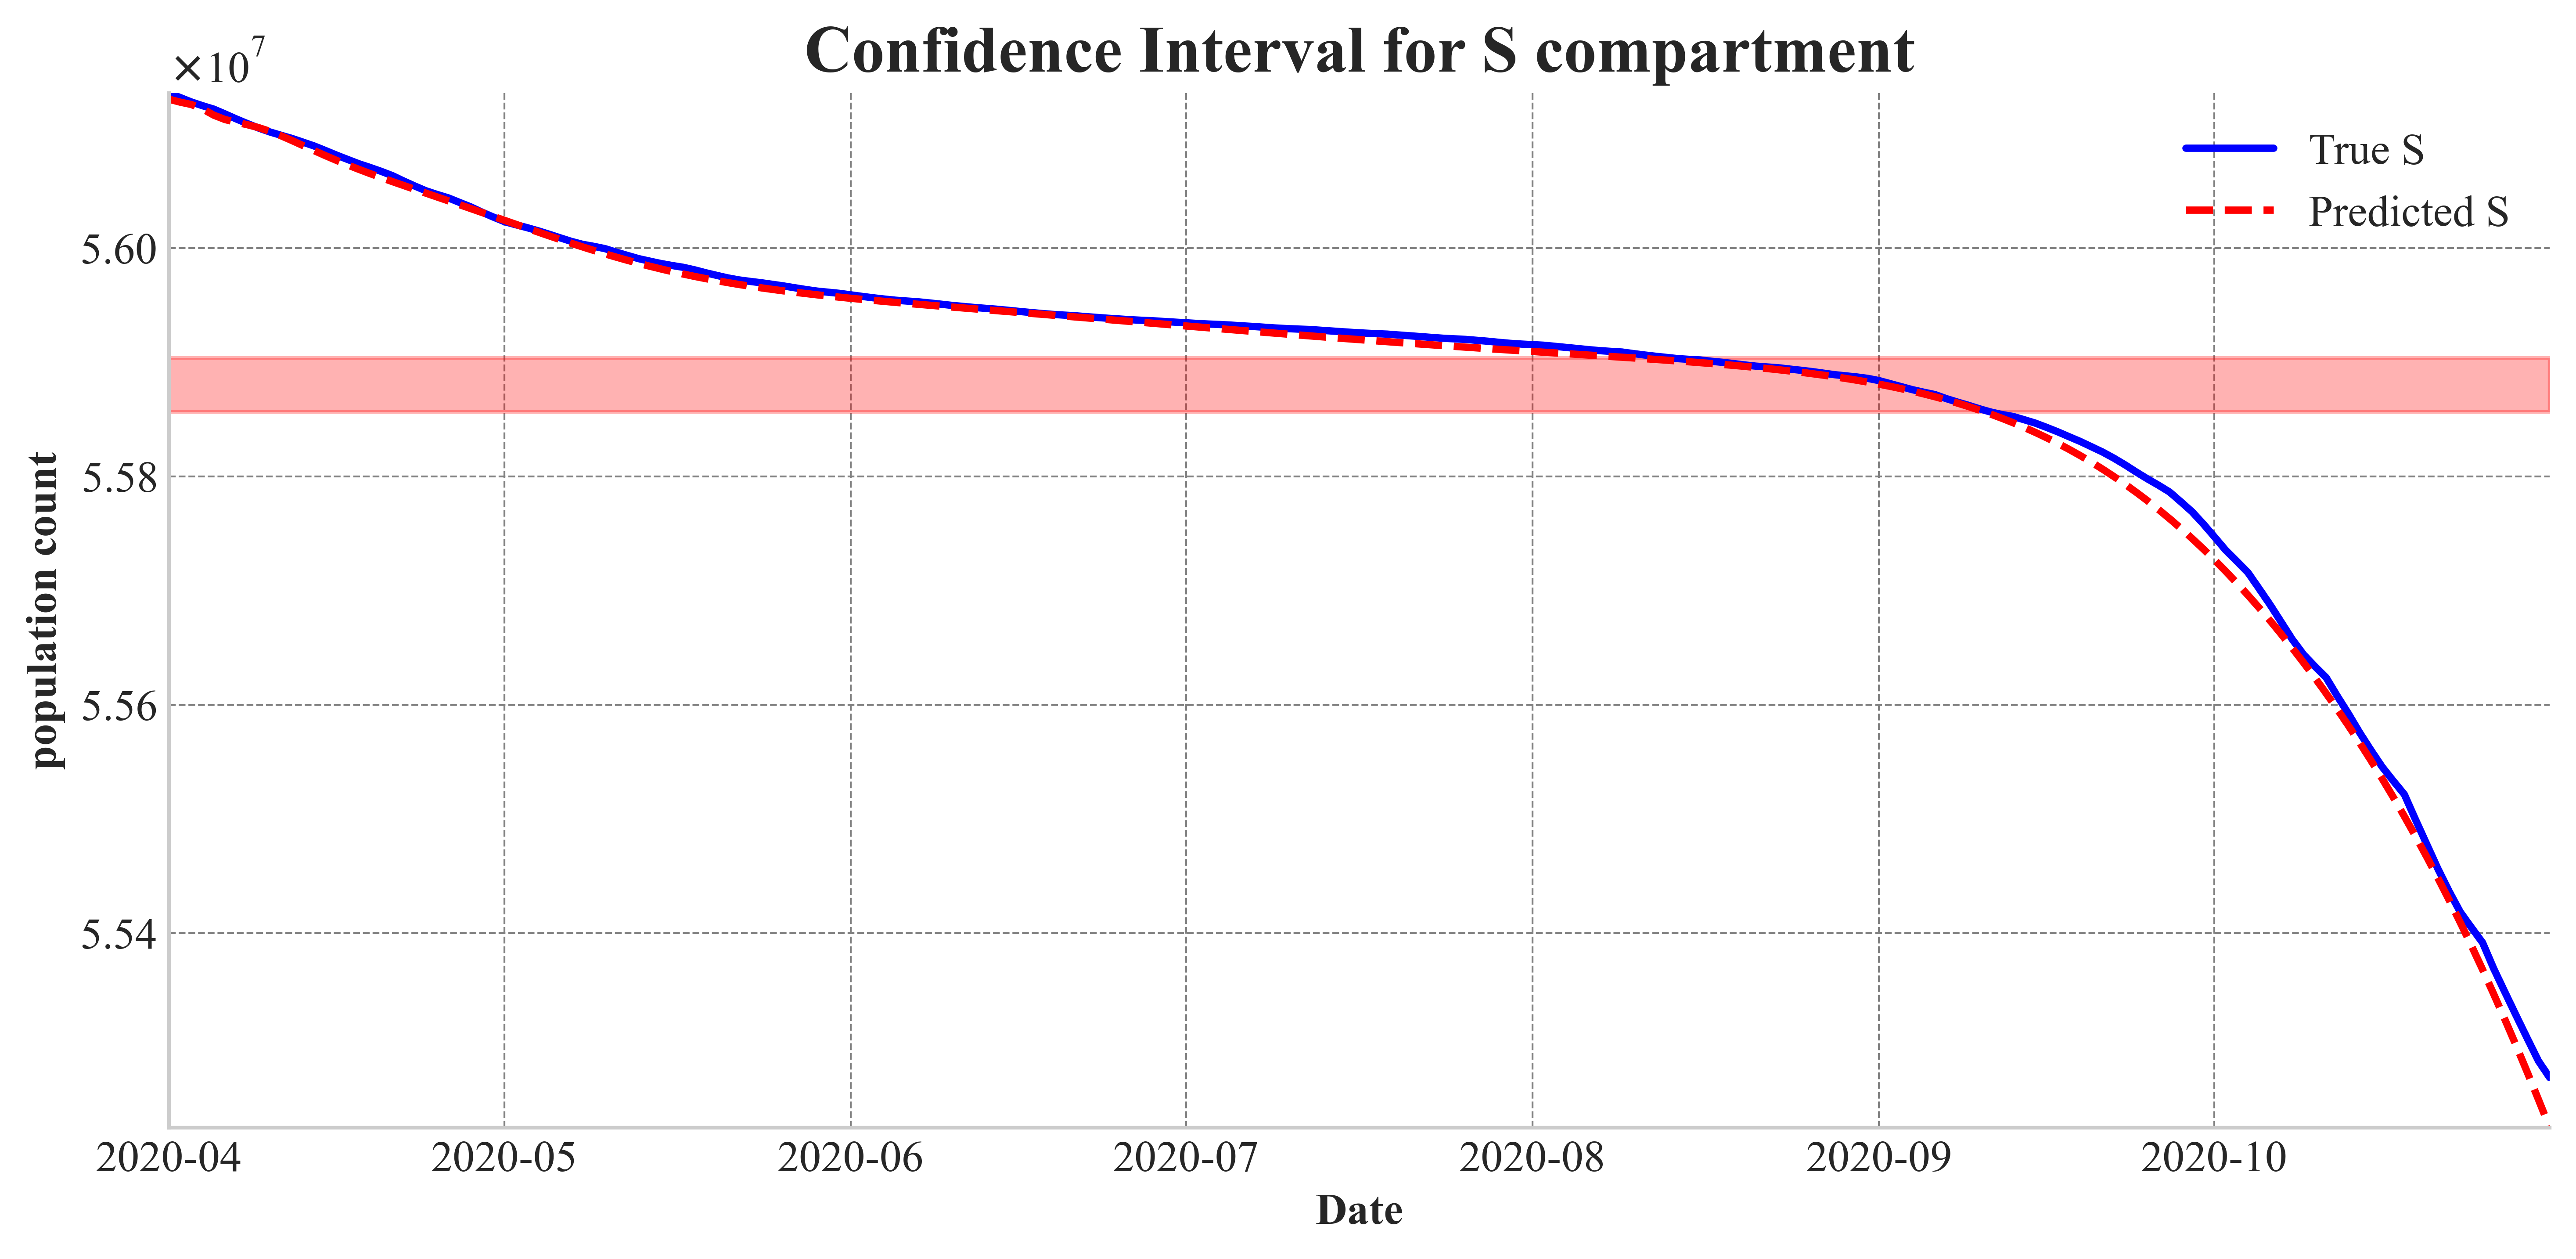

In [ ]:
# Plot the confidence intervals for each compartment
plt.figure(figsize=(10, 5))
plt.plot(data["date"], S_true_rescaled, label="True S", color="blue", linewidth=2)
plt.plot(data["date"], S_pred, label="Predicted S", linestyle="--", color="red", linewidth=2)
plt.fill_between(data["date"], S_lower, S_upper, color="red", alpha=0.3)
plt.title("Confidence Interval for S compartment")
plt.xlabel("Date")
plt.ylabel("population count")
plt.legend()
plt.tight_layout()
# plt.savefig("reports/figures/SIHCRD_S_Confidence_Interval.pdf")
plt.show()

In [ ]:
from scipy.integrate import odeint


In [ ]:
# Number of days to predict
days_to_predict = 7

# Last time point and conditions from your data
last_time_point = data["days_since_start"].values[-1]
last_conditions = data[model_features].values[-1]

# Time points for prediction        
t_pred = np.arange(last_time_point + 1, last_time_point + days_to_predict + 1)



# Parameters from the trained model
beta_estimated = float(model.beta.cpu().detach().numpy())
mu_estimated = float(model.mu.cpu().detach().numpy())
delta_estimated = float(model.delta.cpu().detach().numpy())
xi_estimated = float(model.xi.cpu().detach().numpy())
N = 56171302  # Total population, adjust as per your model

# SIHCRD model definition
def SIHCRD_model(y, t, beta, mu, delta, xi, N):
    S, I, H, C, R, D = y
    gamma = 0.125
    rho = 0.03
    eta = 0.125
    kappa = 0.01875
    dSdt = -(beta * I / N) * S
    dIdt = (beta * S / N) * I - (gamma + rho + delta) * I
    dHdt = rho * I - (eta + kappa) * H
    dCdt = eta * H - (mu + xi) * C
    dRdt = gamma * I + kappa * H + mu * C
    dDdt = delta * I + xi * C
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]

# Solve the ODEs for prediction
predicted_solution = odeint(SIHCRD_model, last_conditions, t_pred, args=(beta_estimated, mu_estimated, delta_estimated, xi_estimated, N))

# rescale predictedd solution
predicted_solution_rescaled = scaler.inverse_transform(predicted_solution)

# Extract the predicted compartments
S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = predicted_solution_rescaled[:, 0], predicted_solution_rescaled[:, 1], predicted_solution_rescaled[:, 2], predicted_solution_rescaled[:, 3], predicted_solution_rescaled[:, 4], predicted_solution_rescaled[:, 5]

actuals = test_data[["S(t)", "active_cases", "hospitalCases", "covidOccupiedMVBeds", "recovered", "new_deceased"]].values

#actual data for the next 7 days after the training data
actual_S = test_data["S(t)"].values
actual_I = test_data["active_cases"].values
actual_H = test_data["hospitalCases"].values
actual_C = test_data["covidOccupiedMVBeds"].values
actual_R = test_data["recovered"].values
actual_D = test_data["new_deceased"].values

# plot the actuals from the text data over the predicted 7days 




In [ ]:
# Initialize a list to collect metrics data for DataFrame
metrics_data = []

# Loop through each compartment and calculate the metrics
for i, comp in enumerate(["S", "I", "H", "C", "R", "D"]):
    # Extract the actual and predicted values for the compartment
    actual = actuals[:, i]
    predicted = predicted_solution_rescaled[:, i]
    
    # Calculate the mean absolute percentage error
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Calculate the mean squared error
    mse = np.mean((actual - predicted) ** 2)
    
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    
    # Append the metrics to the list
    metrics_data.append([comp, mape, mse, rmse])
    
# Create a DataFrame from the metrics data  
metrics_df = pd.DataFrame(metrics_data, columns=["Compartment", "MAPE (%)", "MSE", "RMSE"])

metrics_df.head()           

,Compartment,MAPE (%),MSE,RMSE
0,S,1.347950e-14,5.551115e-17,7.450581e-09
1,I,1.343022e+01,2.914786e+09,5.398876e+04
2,H,2.171138e+01,1.023581e+07,3.199346e+03
3,C,2.601402e+01,1.000472e+05,3.163024e+02
4,R,4.176232e+01,5.143609e+10,2.267953e+05


In [ ]:
# def plot_sihcrd_results(t, S, I, H, C, R, D, model, title):
#     model.eval()
#     with torch.no_grad():
#         predictions = model(t).cpu().numpy()

#     t_np = t.cpu().detach().numpy().flatten()
#     fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted for SIHCRD compartments

#     compartments = [
#         "Susceptible",
#         "Infected",
#         "Hospitalized",
#         "Critical",
#         "Recovered",
#         "Deceased",
#     ]
#     data = [S, I, H, C, R, D]
#     pred_labels = [
#         "S (predicted)",
#         "I (predicted)",
#         "H (predicted)",
#         "C (predicted)",
#         "R (predicted)",
#         "D (predicted)",
#     ]

#     for ax, comp_data, pred, label, pred_label in zip(
#         axs.flat, data, predictions.T, compartments, pred_labels
#     ):
#         if comp_data is not None:
#             ax.plot(t_np, comp_data.cpu().detach().numpy().flatten(), label=label)
#         ax.plot(t_np, pred, linestyle="dashed", label=pred_label)
#         ax.set_title(label)
#         ax.set_xlabel("Time")
#         ax.set_ylabel("Number of Individuals")
#         ax.legend()

#     plt.tight_layout()
#     plt.savefig(f"reports/figures/{title}.pdf")
#     plt.show()

# # Plot the SIHCRD model results
# plot_sihcrd_results(t_train, S_train, I_train, H_train, C_train, R_train, D_train, model, "SIHCRD_Model_Predictions")

In [ ]:
# # parameter estimation neural network where 
# class ParamNet(nn.Module):
#     def __init__(self, output_size=2, num_layers=3, hidden_neurons=20):
#         super(ParamNet, self).__init__()
#         layers = [nn.Linear(1, hidden_neurons), nn.ReLU()]
#         for _ in range(num_layers - 1):
#             layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.ReLU()])
#         layers.append(nn.Linear(hidden_neurons, output_size))
#         self.net = nn.Sequential(*layers)

#     def forward(self, t):
#         return self.net(t)
    
#     # parameter estimation range for beta 0.1 to 1.0
#     @property
#     def beta(self):
#         return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None
    
#     # # parameter estimation range for gamma 0.01 to 0.2
#     # @property
#     # def gamma(self):
#     #     return torch.sigmoid(self._gamma) * 0.19 + 0.01 if self._gamma is not None else None
    
#     # # parameter estimation range for rho 0.01 to 0.2
#     # @property
#     # def rho(self):
#     #     return torch.sigmoid(self._rho) * 0.19 + 0.01 if self._rho is not None else None
    
#     # parameter estimation range for eta 0.01 to 0.2
#     # @property
#     # def eta(self):
#     #     return torch.sigmoid(self._eta) * 0.19 + 0.01 if self._eta is not None else None
    
#     # # parameter estimation range for kappa 0.001 to 0.01
#     # @property
#     # def kappa(self):
#     #     return torch.sigmoid(self._kappa) * 0.009 + 0.001 if self._kappa is not None else None
    
#     # parameter estimation range for mu 0.01 to 0.2
#     @property
#     def mu(self):
#         return torch.sigmoid(self._mu) * 0.19 + 0.01 if self._mu is not None else None
    
#     # parameter estimation range for xi 0.005 to 0.1    
#     @property
#     def xi(self):
#         return torch.sigmoid(self._xi) * 0.095 + 0.005 if self._xi is not None else None
    
#     # parameter estimation range for delta 0.01 to 0.2
#     @property
#     def delta(self):
#         return torch.sigmoid(self._delta) * 0.19 + 0.01 if self._delta is not None else None
    

# # class GRUParamNet(nn.Module):
# #     def __init__(self, input_size=1, hidden_size=20, num_layers=1, output_size=7):
# #         """
# #         Initializes the GRUParamNet model.
# #         input_size: int, number of input features (default is 1 for time).
# #         hidden_size: int, number of features in the hidden state of the GRU.
# #         num_layers: int, number of recurrent layers.
# #         output_size: int, number of output parameters to estimate.
# #         """
# #         super(GRUParamNet, self).__init__()
# #         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
# #         self.fc = nn.Linear(hidden_size, output_size)

# #     def forward(self, x):
# #         """
# #         Forward pass through the GRU model followed by a linear layer.
# #         x: torch.Tensor, input tensor of shape (batch_size, sequence_length, input_size).
# #         """
# #         x, h_n = self.gru(x)  # x: (batch_size, seq_len, hidden_size), h_n: (num_layers, batch_size, hidden_size)
# #         # We use the last hidden state
# #         x = x[:, -1, :]
# #         x = self.fc(x)
# #         # Apply sigmoid activation function to ensure outputs are in the range (0, 1)
# #         parameters = torch.sigmoid(x)
        
# #         # Scale parameters according to their expected ranges
# #         beta = parameters[:, 0] * 0.9 + 0.1 
# #         gamma = parameters[:, 1] * 0.09 + 0.01
# #         rho = parameters[:, 2] * 0.09 + 0.01
# #         eta = parameters[:, 3] * 0.09 + 0.01
# #         theta = parameters[:, 4] * 0.009 + 0.001
# #         return beta, gamma, rho, eta, theta
    
        


# class EpiNet(nn.Module):
#     def __init__(self, num_layers=3, hidden_neurons=20):
#         super(EpiNet, self).__init__()
#         self.retrain_seed = 42  # Set the retrain_seed for reproducibility
#         layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
#         for _ in range(num_layers - 1):
#             layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
#         layers.append(nn.Linear(hidden_neurons, 3))  # Output: S, I, R
#         self.net = nn.Sequential(*layers)
#         self.init_xavier()

#     def forward(self, t):
#         return self.net(t)

#     def init_xavier(self):
#         torch.manual_seed(self.retrain_seed)

#         def init_weights(m):
#             if isinstance(m, nn.Linear):
#                 g = nn.init.calculate_gain("tanh")
#                 nn.init.xavier_uniform_(m.weight, gain=g)
#                 if m.bias is not None:
#                     m.bias.data.fill_(0)

#         self.apply(init_weights)

In [ ]:
# # Define the loss function for the SIHCRD model
# def time_varying_PINN_loss(
#     model,
#     model_output,
#     SIHCRD_tensor_train,
#     t_train,
#     N,
#     beta=None,
#     mu=None,
#     delta=None,
#     xi=None
# ):
#     S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5]
#     S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor_train[:, 0], SIHCRD_tensor_train[:, 1], SIHCRD_tensor_train[:, 2], SIHCRD_tensor_train[:, 3], SIHCRD_tensor_train[:, 4], SIHCRD_tensor_train[:, 5]
    
#     #derivatives of the compartments with respect to time
#     S_t = torch.autograd.grad(S_pred, t_train, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
#     I_t = torch.autograd.grad(I_pred, t_train, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
#     H_t = torch.autograd.grad(H_pred, t_train, grad_outputs=torch.ones_like(H_pred), create_graph=True)[0]
#     C_t = torch.autograd.grad(C_pred, t_train, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
#     R_t = torch.autograd.grad(R_pred, t_train, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
#     D_t = torch.autograd.grad(D_pred, t_train, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
#     # fixed parameters
#     gamma = 0.125
#     rho = 0.03
#     eta = 0.125
#     kappa = 0.01875
    
#     # Time varying parameters 
#     beta = model.beta
#     mu = model.mu
#     delta = model.delta
#     xi = model.xi   
    
#     # SIHCRD model equations
#     dSdt = -(beta * I_true / N) * S_true
#     dIdt = (beta * S_true / N) * I_true - (gamma + rho + delta) * I_true
#     dHdt = rho * I_true - (eta + kappa) * H_true
#     dCdt = eta * H_true - (mu + xi) * C_true
#     dRdt = gamma * I_true + kappa * H_true + mu * C_true
#     dDdt = delta * I_true + xi * C_true
    
#     # physical informed loss
#     loss = nn.MSELoss()(S_t, dSdt) + nn.MSELoss()(I_t, dIdt) + nn.MSELoss()(H_t, dHdt) + nn.MSELoss()(C_t, dCdt) + nn.MSELoss()(R_t, dRdt) + nn.MSELoss()(D_t, dDdt)
    
#     # data fitting loss
#     loss += nn.MSELoss()(S_pred, S_true) + nn.MSELoss()(I_pred, I_true) + nn.MSELoss()(H_pred, H_true) + nn.MSELoss()(C_pred, C_true) + nn.MSELoss()(R_pred, R_true) + nn.MSELoss()(D_pred, D_true)
    
#     return loss



In [ ]:
# # Initialize the models
# # param_model = GRUParamNet(input_size=1, hidden_size=32, num_layers=5).to(device)
# param_net = ParamNet(output_size=7, num_layers=5, hidden_neurons=32).to(device)
# epi_model = EpiNet(num_layers=7, hidden_neurons=32).to(device)

In [ ]:
# # Training function
# def time_varying_PINN_training(
#     param_model,
#     epi_model,
#     t_train,
#     SIHCRD_tensor_train,
#     epochs=1000,
#     lr=0.001,
#     N=None,
#     beta=None,
#     mu=None,
#     delta=None,
#     xi=None,
#     patience=20,
# ):
    
#     param_optimizer = optim.Adam(param_model.parameters(), lr=lr)
#     epi_optimizer = optim.Adam(epi_model.parameters(), lr=lr)
#     early_stopping = EarlyStopping(patience=patience, verbose=True)
    
#     losses = []
    
#     for i in tqdm(range(epochs)):
#         param_model.train()
#         epi_model.train()
        
#         param_optimizer.zero_grad()
#         epi_optimizer.zero_grad()
        
#         # Get the parameters from the parameter estimation model
#         parameters = param_model(t_train)
        
#         # Get the parameters from the parameter estimation model
#         beta = parameters[:, 0]
#         mu = parameters[:, 1]
#         delta = parameters[:, 2]
#         xi = parameters[:, 3]
        
#         # Concatenate the parameters with the time tensor
#         t_params = torch.cat((t_train, parameters), dim=1)
        
#         # Get the model output from the epidemiological model
#         model_output = epi_model(t_params)
        
#         # Calculate the loss
#         loss = time_varying_PINN_loss(epi_model, model_output, SIHCRD_tensor_train, t_train, N, beta, mu, delta, xi)
        
#         # Backward pass
#         loss.backward()
        
#         # Optimizer step
#         param_optimizer.step()
#         epi_optimizer.step()
        
#         losses.append(loss.item())
        
#         if i % 500 == 0:
#             print(f"Epoch {i} Loss: {loss.item():.4f}")
            
#         # Early stopping
#         early_stopping(loss)
        
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break
        
#     return losses


In [ ]:
# losses = time_varying_PINN_training(
#     param_net,
#     epi_model,
#     t_train,
#     SIHCRD_tensor_train,
#     epochs=10000,
#     lr=1e-4,
#     N=params["N"],
#     patience=20,
# )